# Obligatorio DL

Felipe Burgos (208166)
Gabriela Carrasco (259373)
Oliver Kaminski (338835)

## Instalacion e importacion de librerias

In [ ]:
pip install pandas numpy matplotlib seaborn datetime tensorflow scikit-learn ipython pydot imbalanced-learn


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: C:\Users\fabur\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
 #importación de librerías básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os
import numpy as np
import pandas as pd

# Keras

import tensorflow.keras as keras
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.datasets import boston_housing
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models
import tensorflow_datasets as tfds
from tensorflow.keras import layers

# Scikit

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    RocCurveDisplay,
    PrecisionRecallDisplay)

# Weights and Biases related imports
import wandb
from wandb.integration.keras import WandbMetricsLogger
from wandb.integration.keras import WandbModelCheckpoint


# Mics
from IPython.display import Image
from collections import Counter
from imblearn.over_sampling import SMOTE

## Introduccion

Esta notebook presenta la resolución del obligatorio de la materia Deep Learning Aplicado al Análisis de Datos, correspondiente al Diploma de Especialización en Big Data de la Universidad ORT Uruguay. El objetivo principal es desarrollar un análisis completo y la aplicación de técnicas avanzadas de aprendizaje profundo para abordar un problema de predicción basado en el dataset "Crime Data from 2020 to Present", logrando entrenar modelos capaces de predecir el estatus de cada crimen (columna "Status"), considerando el balance de clases durante el entrenamiento.

Alcance del Proyecto:

    1. Análisis Exploratorio de Datos (EDA):
Realizamos una exploración inicial del dataset con visualizaciones y métricas descriptivas, identificando patrones, outliers y características relevantes para la predicción.

    2. Preprocesamiento:
Aplicamos técnicas de limpieza, imputación de valores faltantes y balanceo de clases para asegurar la calidad de los datos y mitigar problemas como el desbalanceo en las clases de salida.

    3. Modelado:
Entrenamos y evaluamos modelos de deep learning para predecir el estatus de los crímenes (columna "Status"). Incorporamos regularización, optimización de hiperparámetros y técnicas de seguimiento de experimentos.

    4. Métricas y Evaluación:
Optimizamos los modelos para obtener un rendimiento mínimo del 65% en la métrica seleccionada. Evaluamos el desempeño utilizando precisión, recall, F1-Score y ROC-AUC.

    5. Seguimiento de Experimentos:
Integramos herramientas como Weights & Biases para rastrear los resultados, analizar los experimentos y seleccionar el modelo más efectivo.

Objetivos Específicos
* Implementar al menos dos técnicas de regularización.
* Aplicar estrategias de optimización de hiperparámetros.
* Justificar decisiones en todas las etapas, desde la limpieza de datos hasta la selección de modelos y métricas.

## Seteo de directorio de trabajo

In [ ]:
file_path = "C:\\Users\\fabur\\Downloads\\Crime_Data_from_2020_to_Present.csv"
rs = pd.read_csv(file_path)
print(rs.head())



       DR_NO               Date Rptd                DATE OCC  TIME OCC  AREA  \
0  190326475  03/01/2020 12:00:00 AM  03/01/2020 12:00:00 AM      2130     7   
1  200106753  02/09/2020 12:00:00 AM  02/08/2020 12:00:00 AM      1800     1   
2  200320258  11/11/2020 12:00:00 AM  11/04/2020 12:00:00 AM      1700     3   
3  200907217  05/10/2023 12:00:00 AM  03/10/2020 12:00:00 AM      2037     9   
4  220614831  08/18/2022 12:00:00 AM  08/17/2020 12:00:00 AM      1200     6   

   AREA NAME  Rpt Dist No  Part 1-2  Crm Cd  \
0   Wilshire          784         1     510   
1    Central          182         1     330   
2  Southwest          356         1     480   
3   Van Nuys          964         1     343   
4  Hollywood          666         2     354   

                                Crm Cd Desc  ... Status   Status Desc  \
0                          VEHICLE - STOLEN  ...     AA  Adult Arrest   
1                     BURGLARY FROM VEHICLE  ...     IC   Invest Cont   
2                

## Dataset Column Descriptions

### Crime and Reporting Information
- **DR_NO**:  
  Division of Records Number, an official file number made up of a 2-digit year, area ID, and 5 digits.  
  **API Field Name**: dr_no  
  **Data Type**: Text  

- **Date Rptd**:  
  The date the crime was reported (MM/DD/YYYY).  
  **API Field Name**: date_rptd  
  **Data Type**: Floating Timestamp  

- **DATE OCC**:  
  The date the crime occurred (MM/DD/YYYY).  
  **API Field Name**: date_occ  
  **Data Type**: Floating Timestamp  

- **TIME OCC**:  
  The time the crime occurred in 24-hour military time.  
  **API Field Name**: time_occ  
  **Data Type**: Text  

### Geographic Information
- **AREA**:  
  The LAPD has 21 Community Police Stations referred to as Geographic Areas within the department. These Geographic Areas are sequentially numbered from 1-21.  
  **API Field Name**: area  
  **Data Type**: Text  

- **AREA NAME**:  
  The 21 Geographic Areas or Patrol Divisions are given a name that references a landmark or the surrounding community they serve.  
  **API Field Name**: area_name  
  **Data Type**: Text  

- **Rpt Dist No**:  
  A four-digit code representing a sub-area within a Geographic Area. All crime records reference the "RD" for statistical comparisons. [Find LAPD Reporting Districts](http://geohub.lacity.org/datasets/c4f83909b81d4786aa8ba8a74a4b4db1_4).  
  **API Field Name**: rpt_dist_no  
  **Data Type**: Text  

### Crime Classification
- **Part 1-2**:  
  Indicates whether the crime is classified as Part 1 or Part 2.  
  **API Field Name**: part_1_2  
  **Data Type**: Number  

- **Crm Cd**:  
  Indicates the crime committed.  
  **API Field Name**: crm_cd  
  **Data Type**: Text  

- **Crm Cd Desc**:  
  Defines the Crime Code provided.  
  **API Field Name**: crm_cd_desc  
  **Data Type**: Text  

### Modus Operandi (MO) Information
- **Mocodes**:  
  Modus Operandi: Activities associated with the suspect in the commission of the crime. [List of MO Codes](https://data.lacity.org/api/views/y8tr-7khq/files/3a967fbd-f210-4857-bc52-60230efe256c?download=true&filename=MO%20CODES%20(numerical%20order).pdf).  
  **API Field Name**: mocodes  
  **Data Type**: Text  

### Victim Information
- **Vict Age**:  
  Age of the victim, represented as a two-character numeric value.  
  **API Field Name**: vict_age  
  **Data Type**: Text  

- **Vict Sex**:  
  Sex of the victim: F - Female, M - Male, X - Unknown.  
  **API Field Name**: vict_sex  
  **Data Type**: Text  

- **Vict Descent**:  
  Descent code representing the ethnicity of the victim.
Descent Code: A - Other Asian B - Black C - Chinese D - Cambodian F - Filipino G - Guamanian H - Hispanic/Latin/Mexican I - American Indian/Alaskan Native J - Japanese K - Korean L - Laotian O - Other P - Pacific Islander S - Samoan U - Hawaiian V - Vietnamese W - White X - Unknown Z - Asian Indian

  **API Field Name**: vict_descent  
  **Data Type**: Text  

### Premise Information
- **Premis Cd**:  
  The type of structure, vehicle, or location where the crime took place.  
  **API Field Name**: premis_cd  
  **Data Type**: Number  

- **Premis Desc**:  
  Defines the premise code provided.  
  **API Field Name**: premis_desc  
  **Data Type**: Text  

### Weapon Information
- **Weapon Used Cd**:  
  The type of weapon used in the crime.  
  **API Field Name**: weapon_used_cd  
  **Data Type**: Text  

- **Weapon Desc**:  
  Defines the Weapon Used Code provided.  
  **API Field Name**: weapon_desc  
  **Data Type**: Text  

### Status Information
- **Status**:  
  Status of the case (IC is the default).  
  
  AO - Adult Other
  
  AA - Adult Arrest
  
  IC - Invest Cont
  
  JO - Juv Other
  
  CC - UNK
  
  **API Field Name**: status  
  **Data Type**: Text  

- **Status Desc**:  
  Defines the status code provided.  
  **API Field Name**: status_desc  
  **Data Type**: Text  

### Additional Crime Information
- **Crm Cd 1**:  
  Indicates the primary and most serious crime committed.  
  **API Field Name**: crm_cd_1  
  **Data Type**: Text  

- **Crm Cd 2**:  
  May contain a code for an additional crime, less serious than Crime Code 1.  
  **API Field Name**: crm_cd_2  
  **Data Type**: Text  

- **Crm Cd 3**:  
  May contain a code for an additional crime, less serious than Crime Code 1.  
  **API Field Name**: crm_cd_3  
  **Data Type**: Text  

- **Crm Cd 4**:  
  May contain a code for an additional crime, less serious than Crime Code 1.  
  **API Field Name**: crm_cd_4  
  **Data Type**: Text  

### Location Information
- **LOCATION**:  
  The street address of the crime incident, rounded to the nearest hundred block to maintain anonymity.  
  **API Field Name**: location  
  **Data Type**: Text  

- **Cross Street**:  
  Cross street of rounded address.  
  **API Field Name**: cross_street  
  **Data Type**: Text  

- **LAT**:  
  Latitude of the crime location.  
  **API Field Name**: lat  
  **Data Type**: Number  

- **LON**:  
  Longitude of the crime location.  
  **API Field Name**: lon  
  **Data Type**: Number  

**Definición de parámetros fijos**

In [ ]:
semilla = 123

## Análisis estadístico descriptivo y transformaciones de variables

### Estructura del dataset

 Analisis de las variables presentes en el dataset, interpretando los resultados que surgen de aplicar funciones de .shape() e .info().

In [ ]:
print("Shape of data orders:",rs.shape)
rs.info()

Shape of data orders: (986500, 28)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 986500 entries, 0 to 986499
Data columns (total 28 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DR_NO           986500 non-null  int64  
 1   Date Rptd       986500 non-null  object 
 2   DATE OCC        986500 non-null  object 
 3   TIME OCC        986500 non-null  int64  
 4   AREA            986500 non-null  int64  
 5   AREA NAME       986500 non-null  object 
 6   Rpt Dist No     986500 non-null  int64  
 7   Part 1-2        986500 non-null  int64  
 8   Crm Cd          986500 non-null  int64  
 9   Crm Cd Desc     986500 non-null  object 
 10  Mocodes         840065 non-null  object 
 11  Vict Age        986500 non-null  int64  
 12  Vict Sex        846925 non-null  object 
 13  Vict Descent    846914 non-null  object 
 14  Premis Cd       986486 non-null  float64
 15  Premis Desc     985915 non-null  object 
 16  Weapon Used Cd  32636

El conjunto de datos consta de 986,500 registros y 28 columnas, incluyendo variables categóricas, numéricas y de texto. Algunas columnas tienen valores faltantes, como Mocodes, Vict Sex y Weapon Used Cd. Las variables geográficas (LAT, LON) están completas. Su tamaño y diversidad ofrecen un amplio potencial para análisis descriptivos y predictivos, el manejo de los valores nulos sera importante para nuestro analisis.

Se aplica función describe para tener un panorama general de las métricas de todas las variables.

In [ ]:
pd.options.display.float_format = '{:.2f}'.format
rs.columns
rs.describe()

,DR_NO,TIME OCC,AREA,Rpt Dist No,Part 1-2,Crm Cd,Vict Age,Premis Cd,Weapon Used Cd,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LAT,LON
count,986500.00,986500.00,986500.00,986500.00,986500.00,986500.00,986500.00,986486.00,326368.00,986489.00,68912.00,2310.00,64.00,986500.00,986500.00
mean,219826982.85,1339.09,10.70,1116.25,1.40,500.78,29.05,306.05,363.85,500.54,958.16,984.20,991.22,34.00,-118.08
std,12992400.41,651.46,6.11,611.00,0.49,206.09,21.98,219.16,123.70,205.89,110.25,51.50,27.07,1.63,5.66
min,817.00,1.00,1.00,101.00,1.00,110.00,-4.00,101.00,101.00,110.00,210.00,310.00,821.00,0.00,-118.67
25%,210610311.75,900.00,5.00,587.00,1.00,331.00,0.00,101.00,311.00,331.00,998.00,998.00,998.00,34.01,-118.43
50%,220817374.50,1420.00,11.00,1141.00,1.00,442.00,30.00,203.00,400.00,442.00,998.00,998.00,998.00,34.06,-118.32
75%,231004872.25,1900.00,16.00,1617.00,2.00,626.00,44.00,501.00,400.00,626.00,998.00,998.00,998.00,34.16,-118.27
max,249928885.00,2359.00,21.00,2199.00,2.00,956.00,120.00,976.00,516.00,956.00,999.00,999.00,999.00,34.33,0.00


El análisis del dataset muestra una variabilidad significativa en las categorías, como áreas (AREA) y códigos de crimen (Crm Cd). Las edades de las víctimas presentan un rango amplio, destacando posibles outliers que requieren análisis adicional. La granularidad temporal (TIME OCC) y geográfica (LAT, LON) puede ser clave para patrones predictivos.

### Analisis de Valores nulos

In [ ]:
# Verificar valores nulos en el DataFrame
valores_nulos = rs.isnull().sum()
print(valores_nulos)

DR_NO                  0
Date Rptd              0
DATE OCC               0
TIME OCC               0
AREA                   0
AREA NAME              0
Rpt Dist No            0
Part 1-2               0
Crm Cd                 0
Crm Cd Desc            0
Mocodes           146435
Vict Age               0
Vict Sex          139575
Vict Descent      139586
Premis Cd             14
Premis Desc          585
Weapon Used Cd    660132
Weapon Desc       660132
Status                 1
Status Desc            0
Crm Cd 1              11
Crm Cd 2          917588
Crm Cd 3          984190
Crm Cd 4          986436
LOCATION               0
Cross Street      834230
LAT                    0
LON                    0
dtype: int64


Cross Street ,Crm Cd 2 ,    Crm Cd 3    , Crm Cd 4    , Mocodes   ,  VictSex     ,  Vict Descent  , Weapon Used Cd , Weapon Desc   presentan gran porcentaje de nulos.

### Valores duplicados

In [ ]:
valores_duplicados = rs.duplicated().sum()
print(valores_duplicados)

0


El dataset no presenta valores duplicados.

### Tranformacion de variables object a categorias

In [ ]:
# *Transformación y Preparación de Características del Dataset*
# Convertir la columnas a tipo categórico
rs['AREA NAME'] = rs['AREA NAME'].astype('category')

rs['Status Desc'] = rs['Status Desc'].astype('category')
rs['Weapon Desc'] = rs['Weapon Desc'].astype('category')
rs['Crm Cd Desc'] = rs['Crm Cd Desc'].astype('category')
rs['Premis Desc'] = rs['Premis Desc'].astype('category')
rs['Vict Sex'] = rs['Vict Sex'].astype('category')
rs['Vict Descent'] = rs['Vict Descent'].astype('category')
rs['Mocodes'] = rs['Mocodes'].astype('category')
rs['Part 1-2'] = rs['Part 1-2'].astype('category')
rs['Status'] = rs['Status'].astype('category')

# Variable de respuesta
rs['Status Desc'] = rs['Status Desc'].astype('category')

### Analisis rapido de la variable de referencia

In [ ]:
rs['Status Desc'].cat.categories

Index(['Adult Arrest', 'Adult Other', 'Invest Cont', 'Juv Arrest', 'Juv Other',
       'UNK'],
      dtype='object')

C:\Users\fabur\AppData\Local\Temp\ipykernel_12772\360254141.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  resumen_Status_Desc = rs.groupby('Status Desc').agg(


    Status Desc  cantidad
0  Adult Arrest     85377
1   Adult Other    107731
2   Invest Cont    788335
3    Juv Arrest      3212
4     Juv Other      1838
5           UNK         7


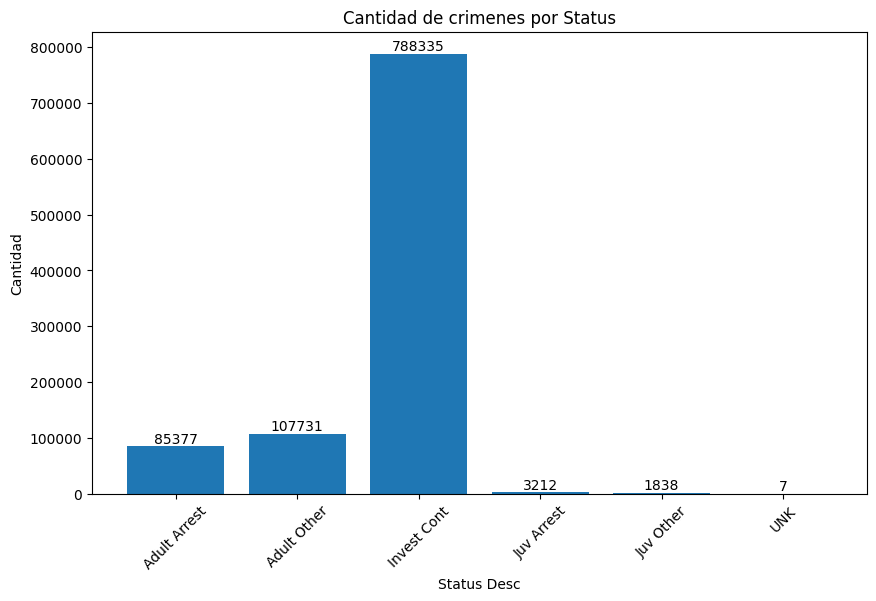

In [ ]:
# Agrupar por 'Status' y contar la cantidad de crimenes en base al estado en que se encuentra
resumen_Status_Desc = rs.groupby('Status Desc').agg(
    cantidad=('Status Desc', 'count')
).reset_index()

# Mostrar los primeros 100 registros del resultado
print(resumen_Status_Desc.head(100))

# Crear una gráfica de barras
plt.figure(figsize=(10, 6))
plt.bar(resumen_Status_Desc['Status Desc'], resumen_Status_Desc['cantidad'])
plt.xlabel('Status Desc')
plt.ylabel('Cantidad')
plt.title('Cantidad de crimenes por Status')
plt.xticks(rotation=45)

# Mostrar los valores en las barras
for index, value in enumerate(resumen_Status_Desc['cantidad']):
    plt.text(index, value, str(value), ha='center', va='bottom')

# Mostrar la gráfica
plt.show()

  Status  cantidad
0     AA     85377
1     AO    107731
2     CC         6
3     IC    788335
4     JA      3212
5     JO      1838


C:\Users\fabur\AppData\Local\Temp\ipykernel_12772\3018292636.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  resumen_Status = rs.groupby('Status').agg(


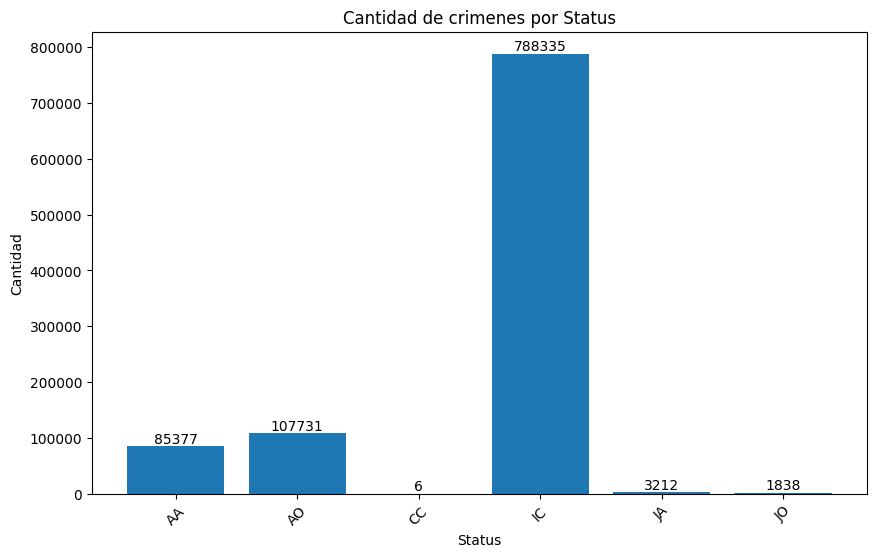

In [ ]:
# Variable de respuesta
# Agrupar por 'Status' y contar la cantidad de crimenes en base al estado en que se encuentra
resumen_Status = rs.groupby('Status').agg(
    cantidad=('Status', 'count')
).reset_index()

# Mostrar los primeros 100 registros del resultado
print(resumen_Status.head(100))

# Crear una gráfica de barras
plt.figure(figsize=(10, 6))
plt.bar(resumen_Status['Status'], resumen_Status['cantidad'])
plt.xlabel('Status')
plt.ylabel('Cantidad')
plt.title('Cantidad de crimenes por Status')
plt.xticks(rotation=45)

# Mostrar los valores en las barras
for index, value in enumerate(resumen_Status['cantidad']):
    plt.text(index, value, str(value), ha='center', va='bottom')

# Mostrar la gráfica
plt.show()

El análisis muestra un desequilibrio extremo en la variable "Status", con "Invest Cont" representando la mayoría de los casos. Esto evidencia un desafío para los modelos predictivos, que requieren estrategias para manejar el desbalance y prevenir sesgos. El análisis confirma que las variables "Status" y "Status Desc" contienen información equivalente. Esta redundancia debe ser gestionada durante la preparación de datos, seleccionando una sola columna para evitar duplicación y optimizar el proceso de modelado.








### Analisis rapido de las variables predictoras categoricas

In [ ]:
rs['AREA NAME'].cat.categories

Index(['77th Street', 'Central', 'Devonshire', 'Foothill', 'Harbor',
       'Hollenbeck', 'Hollywood', 'Mission', 'N Hollywood', 'Newton',
       'Northeast', 'Olympic', 'Pacific', 'Rampart', 'Southeast', 'Southwest',
       'Topanga', 'Van Nuys', 'West LA', 'West Valley', 'Wilshire'],
      dtype='object')

In [ ]:
rs['Weapon Desc'].cat.categories

Index(['AIR PISTOL/REVOLVER/RIFLE/BB GUN', 'ANTIQUE FIREARM',
       'ASSAULT WEAPON/UZI/AK47/ETC', 'AUTOMATIC WEAPON/SUB-MACHINE GUN',
       'AXE', 'BELT FLAILING INSTRUMENT/CHAIN', 'BLACKJACK',
       'BLUNT INSTRUMENT', 'BOARD', 'BOMB THREAT', 'BOTTLE', 'BOW AND ARROW',
       'BOWIE KNIFE', 'BRASS KNUCKLES', 'CAUSTIC CHEMICAL/POISON', 'CLEAVER',
       'CLUB/BAT', 'CONCRETE BLOCK/BRICK', 'DEMAND NOTE', 'DIRK/DAGGER',
       'DOG/ANIMAL (SIC ANIMAL ON)', 'EXPLOXIVE DEVICE', 'FIRE',
       'FIXED OBJECT', 'FOLDING KNIFE', 'GLASS', 'HAMMER', 'HAND GUN',
       'HECKLER & KOCH 91 SEMIAUTOMATIC ASSAULT RIFLE',
       'HECKLER & KOCH 93 SEMIAUTOMATIC ASSAULT RIFLE', 'ICE PICK',
       'KITCHEN KNIFE', 'KNIFE WITH BLADE 6INCHES OR LESS',
       'KNIFE WITH BLADE OVER 6 INCHES IN LENGTH', 'LIQUOR/DRUGS',
       'M-14 SEMIAUTOMATIC ASSAULT RIFLE', 'M1-1 SEMIAUTOMATIC ASSAULT RIFLE',
       'MAC-10 SEMIAUTOMATIC ASSAULT WEAPON',
       'MAC-11 SEMIAUTOMATIC ASSAULT WEAPON', 'MACE/PEPPER SPR

In [ ]:
rs['Crm Cd Desc'].cat.categories

Index(['ARSON', 'ASSAULT WITH DEADLY WEAPON ON POLICE OFFICER',
       'ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT', 'ATTEMPTED ROBBERY',
       'BATTERY - SIMPLE ASSAULT', 'BATTERY ON A FIREFIGHTER',
       'BATTERY POLICE (SIMPLE)', 'BATTERY WITH SEXUAL CONTACT',
       'BEASTIALITY, CRIME AGAINST NATURE SEXUAL ASSLT WITH ANIM', 'BIGAMY',
       ...
       'UNAUTHORIZED COMPUTER ACCESS',
       'VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)',
       'VANDALISM - MISDEAMEANOR ($399 OR UNDER)', 'VEHICLE - ATTEMPT STOLEN',
       'VEHICLE - STOLEN',
       'VEHICLE, STOLEN - OTHER (MOTORIZED SCOOTERS, BIKES, ETC)',
       'VIOLATION OF COURT ORDER', 'VIOLATION OF RESTRAINING ORDER',
       'VIOLATION OF TEMPORARY RESTRAINING ORDER',
       'WEAPONS POSSESSION/BOMBING'],
      dtype='object', length=140)

In [ ]:
rs['Premis Desc'].cat.categories

Index(['7TH AND METRO CENTER (NOT LINE SPECIFIC)',
       'ABANDONED BUILDING ABANDONED HOUSE', 'ABATEMENT LOCATION',
       'ABORTION CLINIC/ABORTION FACILITY*', 'AIRCRAFT', 'ALLEY',
       'AMTRAK TRAIN', 'AMUSEMENT PARK*',
       'APARTMENT/CONDO COMMON LAUNDRY ROOM',
       'ARCADE,GAME ROOM/VIDEO GAMES (EXAMPLE CHUCKIE CHEESE)*',
       ...
       'VALET',
       'VEHICLE STORAGE LOT (CARS, TRUCKS, RV'S, BOATS, TRAILERS, ETC.)',
       'VEHICLE, PASSENGER/TRUCK', 'VETERINARIAN/ANIMAL HOSPITAL',
       'VIDEO RENTAL STORE', 'VISION CARE FACILITY*', 'WAREHOUSE',
       'WATER FACILITY', 'WEBSITE', 'YARD (RESIDENTIAL/BUSINESS)'],
      dtype='object', length=306)

In [ ]:
rs['Vict Sex'].cat.categories

Index(['-', 'F', 'H', 'M', 'X'], dtype='object')

In [ ]:
rs['Vict Descent'].cat.categories

Index(['-', 'A', 'B', 'C', 'D', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'O', 'P',
       'S', 'U', 'V', 'W', 'X', 'Z'],
      dtype='object')

In [ ]:
rs['Mocodes'].cat.categories

Index(['0100', '0100 0104', '0100 0104 0325 0344', '0100 0104 0344',
       '0100 0104 0344 0325', '0100 0104 0344 0352 0378 0325',
       '0100 0104 0344 0378 0325', '0100 0104 1300 0344 0330 1822',
       '0100 0104 1300 1822', '0100 0104 1822 0344 0346 0400',
       ...
       '9999 1275 0325', '9999 1275 0344', '9999 1275 2004', '9999 1822',
       '9999 1822 0321', '9999 1822 0344', '9999 1822 0344 0321 1420',
       '9999 1822 0344 1402 1420 0216 0321', '9999 2004', '9999 2004 0910'],
      dtype='object', length=309567)

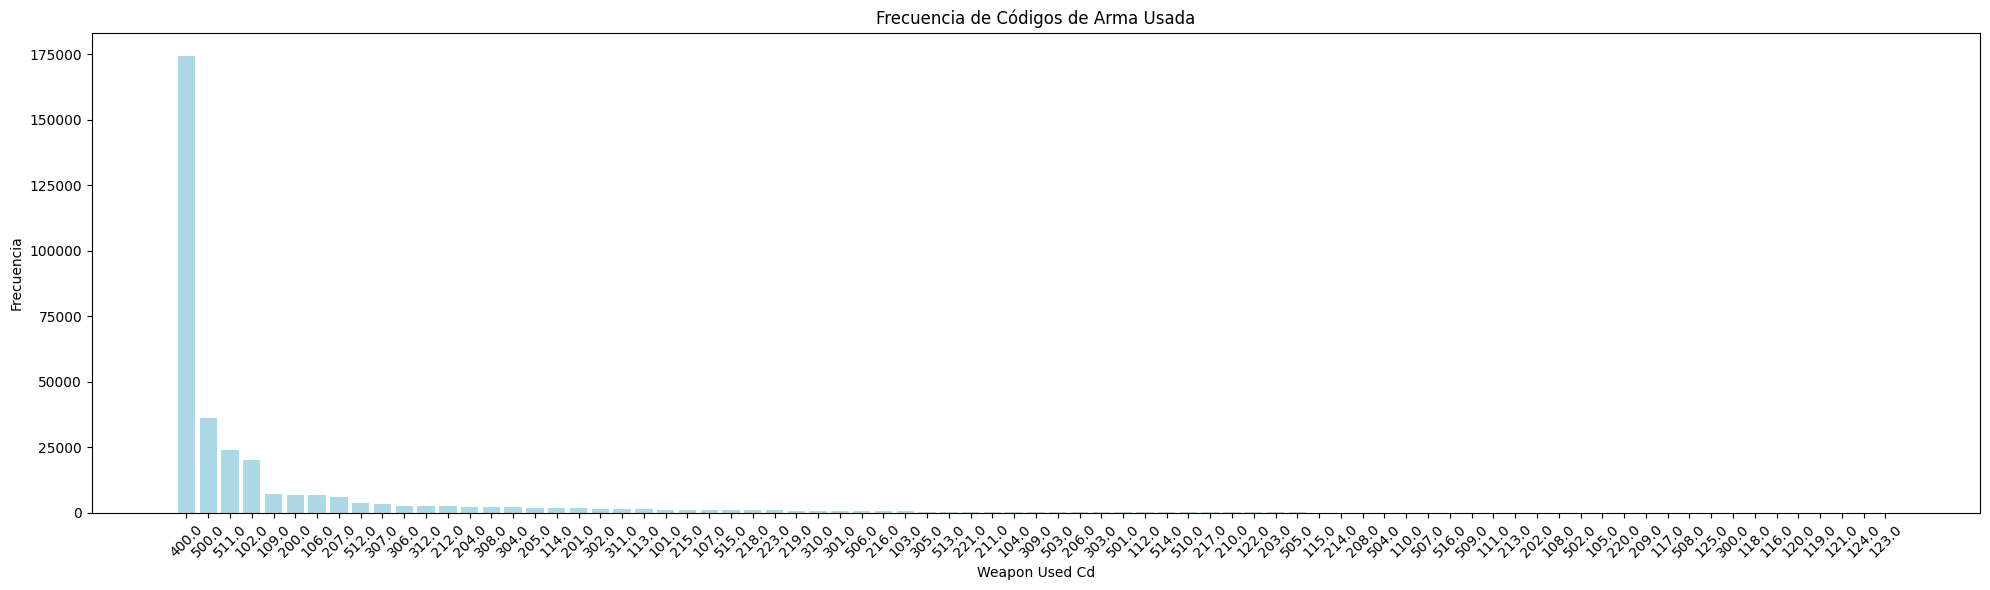

In [ ]:
# Crear una figura
plt.figure(figsize=(20, 6))

# Calcular la frecuencia de cada código de arma utilizada
weapon_counts = rs['Weapon Used Cd'].value_counts()

# Crear el gráfico de barras
plt.bar(weapon_counts.index.astype(str), weapon_counts.values, color='lightblue')
plt.title('Frecuencia de Códigos de Arma Usada')
plt.ylabel('Frecuencia')
plt.xlabel('Weapon Used Cd')
plt.xticks(rotation=45)  # Rotar etiquetas del eje x

# Ajustar el layout
plt.tight_layout()

# Mostrar la gráfica
plt.show()

In [ ]:
# Asegurarse de que la columna sea de tipo categórico
rs['Mocodes'] = rs['Mocodes'].astype('category')

# Contar el número de categorías en Mocodes
num_categorias = rs['Mocodes'].nunique()
print("Número de categorías en Mocodes:", num_categorias)

# Listar las categorías
categorias = rs['Mocodes'].cat.categories
print("Categorías en Mocodes:")
print(categorias)

Número de categorías en Mocodes: 309567
Categorías en Mocodes:
Index(['0100', '0100 0104', '0100 0104 0325 0344', '0100 0104 0344',
       '0100 0104 0344 0325', '0100 0104 0344 0352 0378 0325',
       '0100 0104 0344 0378 0325', '0100 0104 1300 0344 0330 1822',
       '0100 0104 1300 1822', '0100 0104 1822 0344 0346 0400',
       ...
       '9999 1275 0325', '9999 1275 0344', '9999 1275 2004', '9999 1822',
       '9999 1822 0321', '9999 1822 0344', '9999 1822 0344 0321 1420',
       '9999 1822 0344 1402 1420 0216 0321', '9999 2004', '9999 2004 0910'],
      dtype='object', length=309567)


In [ ]:
# Agrupar por 'AREA_NAME' y contar la cantidad de crimenes por Area
resumen_AREA_NAME = rs.groupby('AREA NAME').agg(
    cantidad=('AREA NAME', 'count')
).reset_index()

# Mostrar los primeros 100 registros del resultado
print(resumen_AREA_NAME.head(100))

      AREA NAME  cantidad
0   77th Street     61018
1       Central     68166
2    Devonshire     40985
3      Foothill     32647
4        Harbor     40603
5    Hollenbeck     36287
6     Hollywood     51510
7       Mission     39572
8   N Hollywood     50197
9        Newton     48422
10    Northeast     42050
11      Olympic     49211
12      Pacific     58087
13      Rampart     46001
14    Southeast     49263
15    Southwest     56259
16      Topanga     40591
17     Van Nuys     42059
18      West LA     44848
19  West Valley     41452
20     Wilshire     47272


C:\Users\fabur\AppData\Local\Temp\ipykernel_12772\927981883.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  resumen_AREA_NAME = rs.groupby('AREA NAME').agg(


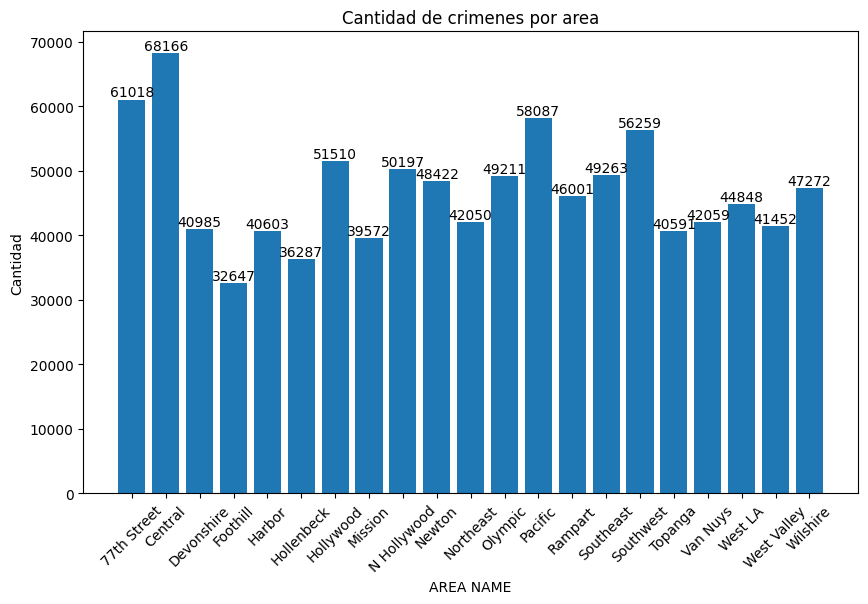

In [ ]:
# Crear una gráfica de barras
plt.figure(figsize=(10, 6))
plt.bar(resumen_AREA_NAME['AREA NAME'], resumen_AREA_NAME['cantidad'])
plt.xlabel('AREA NAME')
plt.ylabel('Cantidad')
plt.title('Cantidad de crimenes por area')
plt.xticks(rotation=45)

# Mostrar los valores en las barras
for index, value in enumerate(resumen_AREA_NAME['cantidad']):
    plt.text(index, value, str(value), ha='center', va='bottom')

# Mostrar la gráfica
plt.show()

C:\Users\fabur\AppData\Local\Temp\ipykernel_12772\339061117.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  resumen_Weapon_Desc = rs.groupby('Weapon Desc').agg(


                         Weapon Desc  cantidad
0   AIR PISTOL/REVOLVER/RIFLE/BB GUN      1858
1                    ANTIQUE FIREARM         9
2        ASSAULT WEAPON/UZI/AK47/ETC        77
3   AUTOMATIC WEAPON/SUB-MACHINE GUN        28
4                                AXE       323
..                               ...       ...
74   UNKNOWN TYPE CUTTING INSTRUMENT       880
75       UNKNOWN WEAPON/OTHER WEAPON     36010
76   UZI SEMIAUTOMATIC ASSAULT RIFLE        10
77                           VEHICLE      3246
78                     VERBAL THREAT     23806

[79 rows x 2 columns]


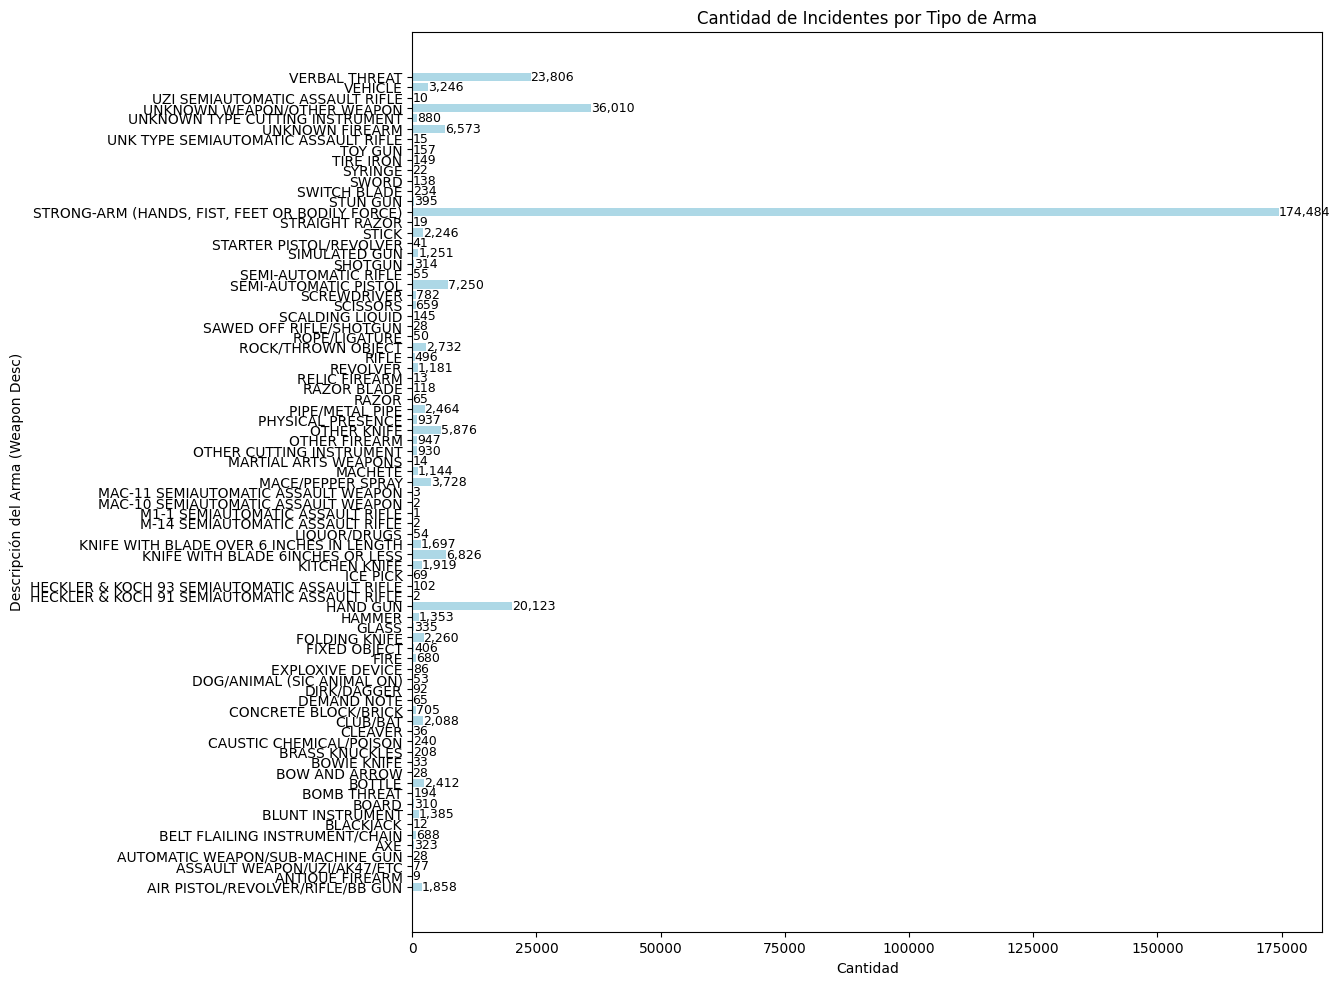

In [ ]:
# Agrupar por 'Weapon Desc' y contar la cantidad de Incidentes por Tipo de Arma
resumen_Weapon_Desc = rs.groupby('Weapon Desc').agg(
    cantidad=('Weapon Desc', 'count')
).reset_index()

# Mostrar los primeros 100 registros del resultado
print(resumen_Weapon_Desc.head(100))

# Crear una figura para la gráfica
plt.figure(figsize=(14, 10))

# Crear el gráfico de barras horizontal
bars = plt.barh(resumen_Weapon_Desc['Weapon Desc'], resumen_Weapon_Desc['cantidad'], color='lightblue')

# Configurar las etiquetas del eje x y del eje y
plt.xlabel('Cantidad')
plt.ylabel('Descripción del Arma (Weapon Desc)')
plt.title('Cantidad de Incidentes por Tipo de Arma')

# Mostrar los valores en las barras
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height() / 2, f'{int(width):,}', ha='left', va='center', fontsize=9, color='black')

# Ajustar los márgenes
plt.subplots_adjust(left=0.3, right=0.95, top=0.95, bottom=0.05)

# Mostrar la gráfica
plt.show()


C:\Users\fabur\AppData\Local\Temp\ipykernel_12772\1581621372.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  resumen_Premis_Desc = rs.groupby('Premis Desc').agg(


                                 Premis Desc  cantidad
0   7TH AND METRO CENTER (NOT LINE SPECIFIC)       260
1         ABANDONED BUILDING ABANDONED HOUSE      1089
2                         ABATEMENT LOCATION        10
3         ABORTION CLINIC/ABORTION FACILITY*        12
4                                   AIRCRAFT        27
..                                       ...       ...
95                                   HOSPICE        28
96                                  HOSPITAL      2378
97                                     HOTEL      5427
98                             JEWELRY STORE       432
99                        JUNIOR HIGH SCHOOL      1924

[100 rows x 2 columns]


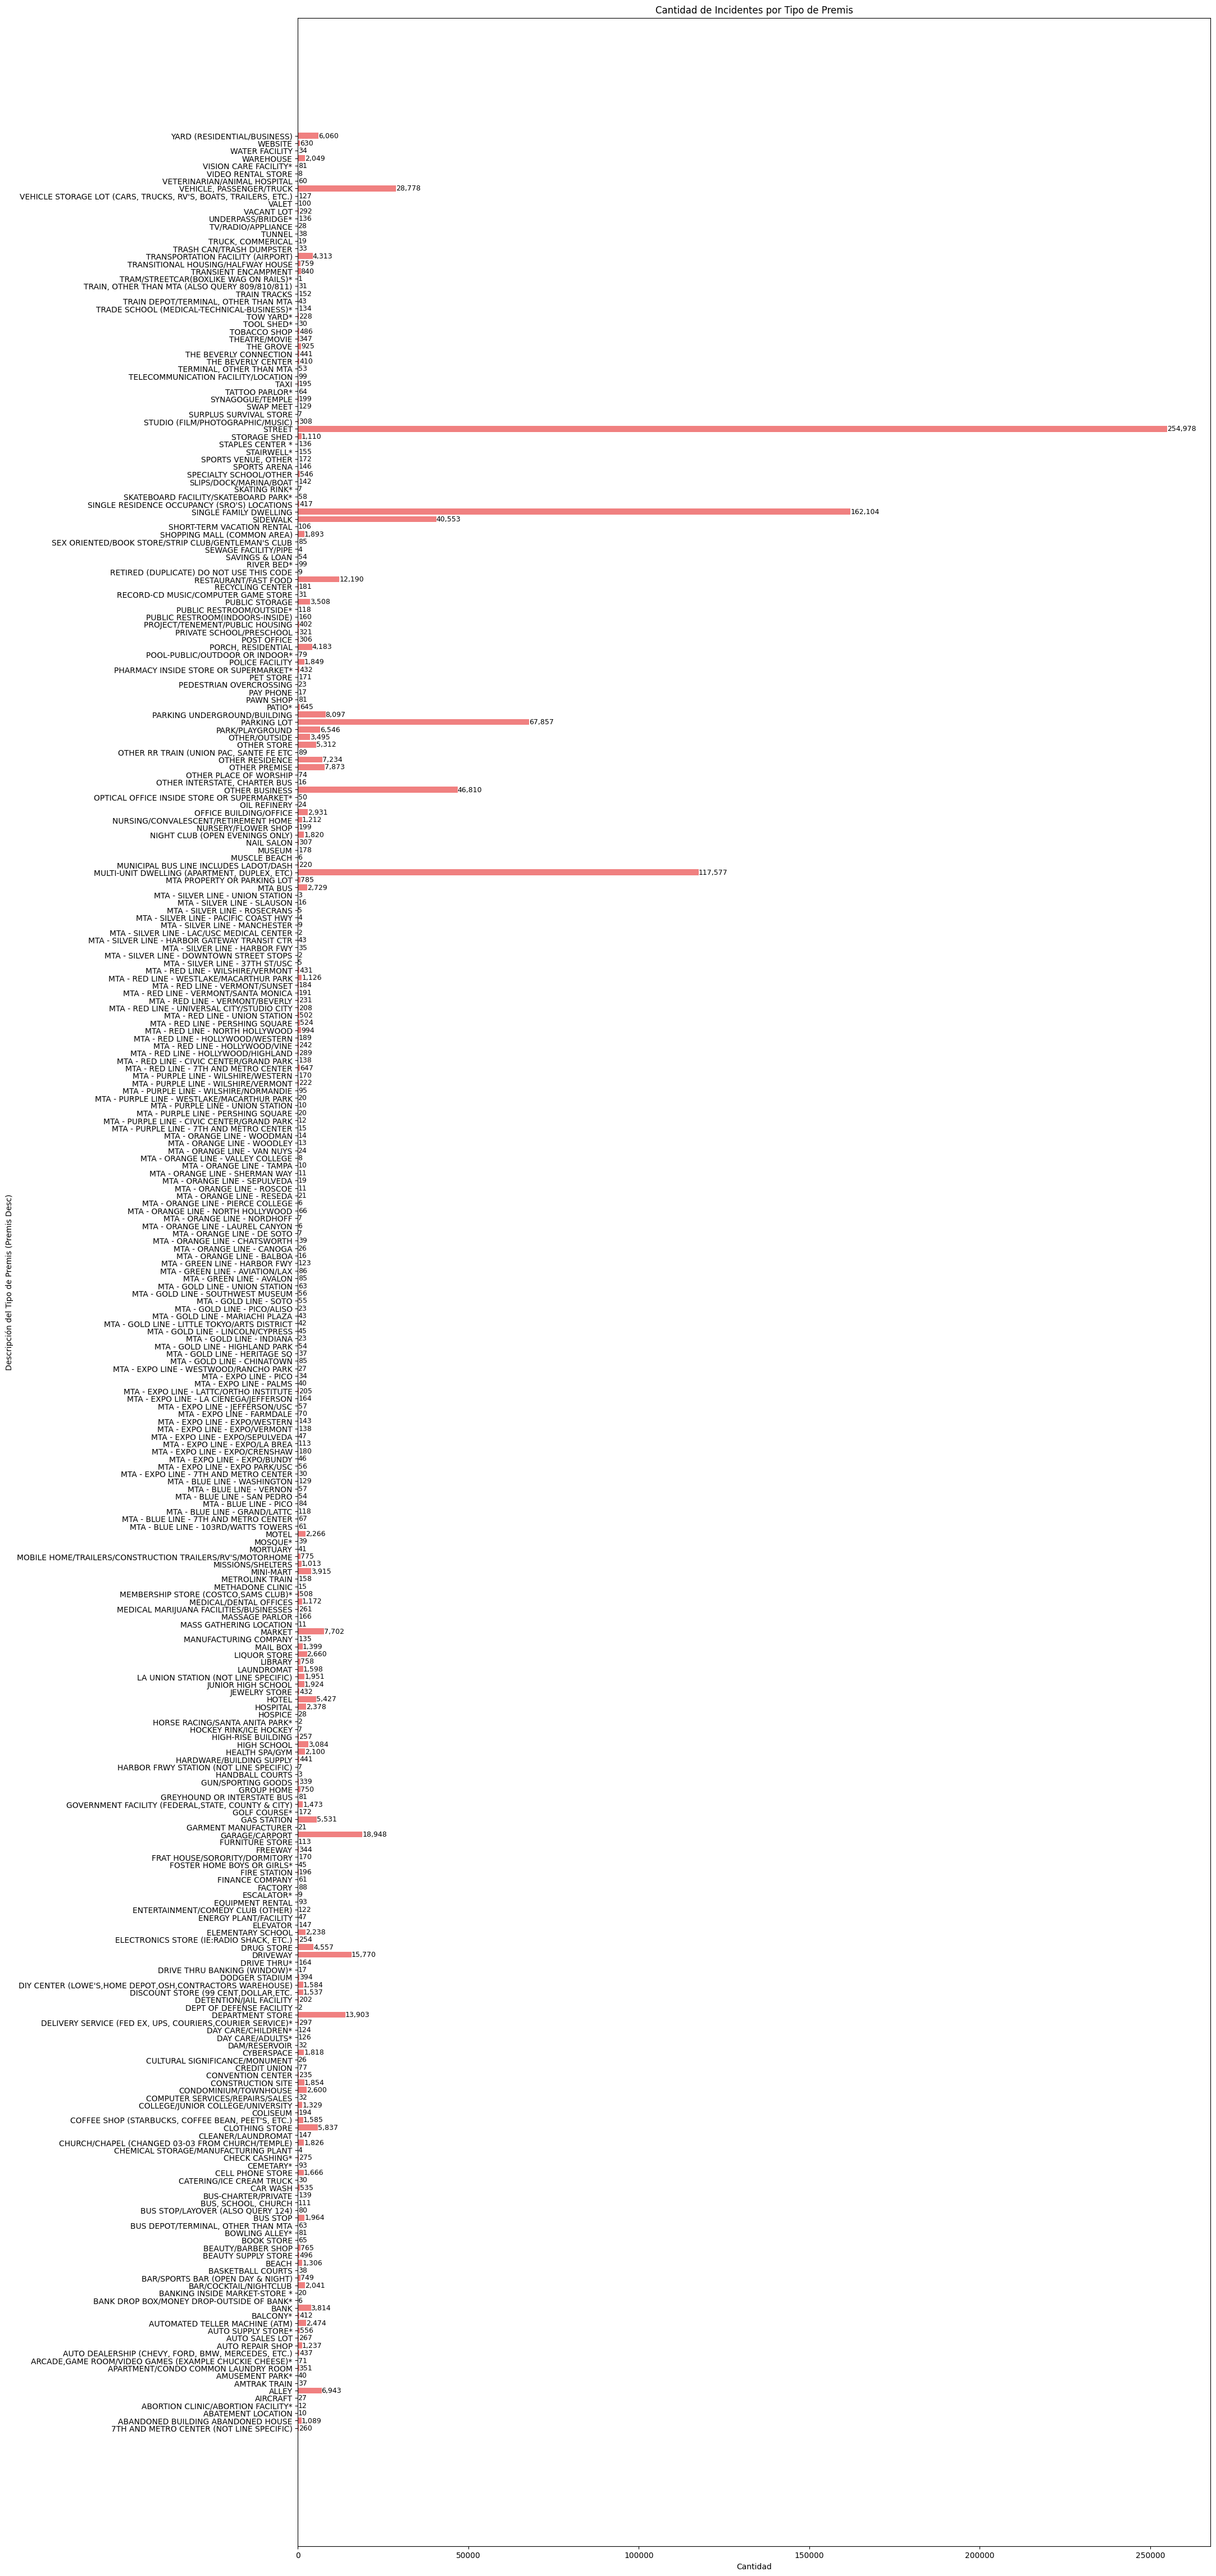

In [ ]:
import matplotlib.pyplot as plt

# Agrupar por 'Premis Desc' y contar la cantidad de crimenes por lugar del incidente
resumen_Premis_Desc = rs.groupby('Premis Desc').agg(
    cantidad=('Premis Desc', 'count')
).reset_index()

# Mostrar los primeros 100 registros del resultado
print(resumen_Premis_Desc.head(100))

# Crear una figura para la gráfica
plt.figure(figsize=(25, 50))

# Crear el gráfico de barras horizontal
bars = plt.barh(resumen_Premis_Desc['Premis Desc'], resumen_Premis_Desc['cantidad'], color='lightcoral')

# Configurar las etiquetas del eje x y del eje y
plt.xlabel('Cantidad')
plt.ylabel('Descripción del Tipo de Premis (Premis Desc)')
plt.title('Cantidad de Incidentes por Tipo de Premis')

# Mostrar los valores en las barras
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height() / 2, f'{int(width):,}', ha='left', va='center', fontsize=9, color='black')

# Ajustar los márgenes
plt.subplots_adjust(left=0.3, right=0.95, top=0.95, bottom=0.05)

# Mostrar la gráfica
plt.show()


  Vict Sex  cantidad
0        -         1
1        F    353688
2        H       112
3        M    397948
4        X     95176


C:\Users\fabur\AppData\Local\Temp\ipykernel_12772\88931136.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  resumen_Vict_Sex = rs.groupby('Vict Sex').agg(


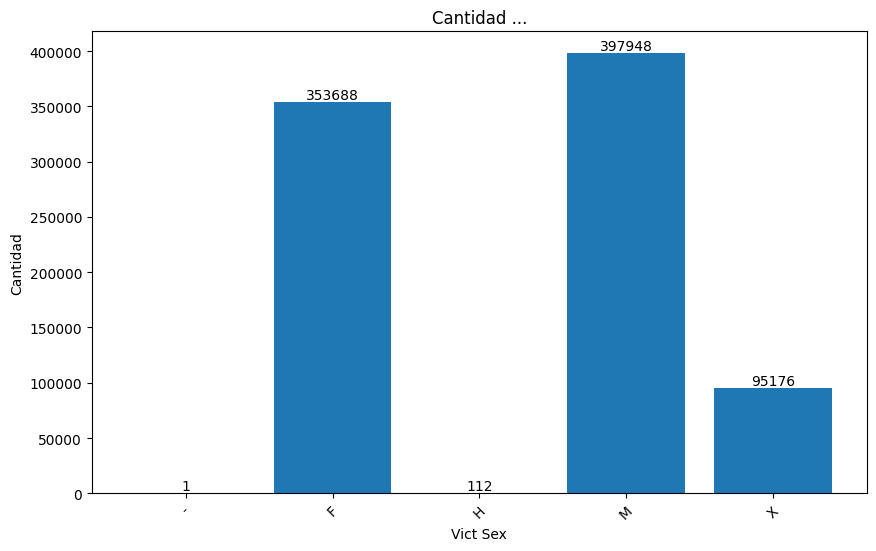

In [ ]:
# Agrupar por 'Vict_Sex' y contar la cantidad de victimas categorizadas por el sexo
resumen_Vict_Sex = rs.groupby('Vict Sex').agg(
    cantidad=('Vict Sex', 'count')
).reset_index()

# Mostrar los primeros 100 registros del resultado
print(resumen_Vict_Sex.head(100))

# Crear una gráfica de barras
plt.figure(figsize=(10, 6))
plt.bar(resumen_Vict_Sex['Vict Sex'],resumen_Vict_Sex['cantidad'])
plt.xlabel('Vict Sex')
plt.ylabel('Cantidad')
plt.title('Cantidad ...')
plt.xticks(rotation=45)

# Mostrar los valores en las barras
for index, value in enumerate(resumen_Vict_Sex['cantidad']):
    plt.text(index, value, str(value), ha='center', va='bottom')

# Mostrar la gráfica
plt.show()

C:\Users\fabur\AppData\Local\Temp\ipykernel_12772\2392302106.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  resumen_Vict_Descent = rs.groupby('Vict Descent').agg(


   Vict Descent  cantidad
0             -         2
1             A     21081
2             B    134449
3             C      4330
4             D        88
5             F      4592
6             G        72
7             H    293088
8             I       980
9             J      1506
10            K      5720
11            L        73
12            O     76983
13            P       279
14            S        55
15            U       212
16            V      1128
17            W    197773
18            X    103966
19            Z       537


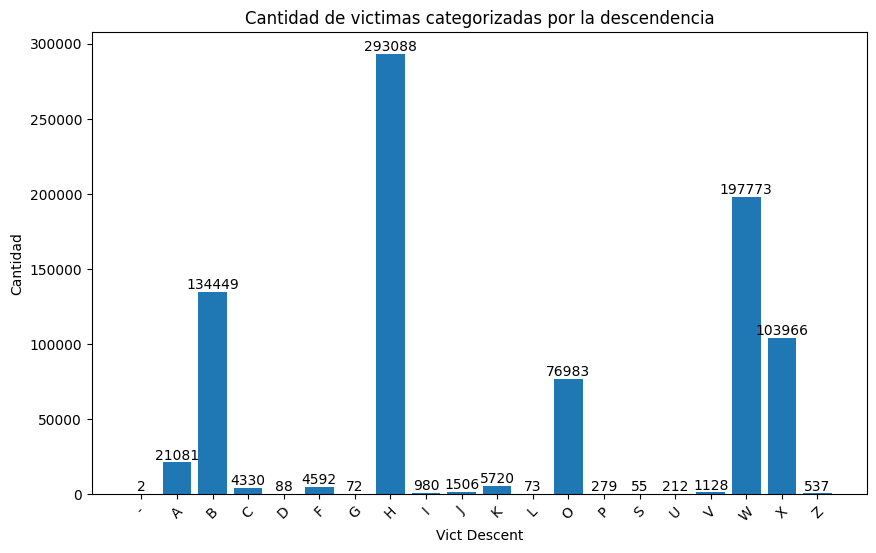

In [ ]:
# Agrupar por 'Vict_Descent' y contar la cantidad de victimas categorizadas por la descendencia
resumen_Vict_Descent = rs.groupby('Vict Descent').agg(
    cantidad=('Vict Descent', 'count')
).reset_index()

# Mostrar los primeros 100 registros del resultado
print(resumen_Vict_Descent.head(100))

# Crear una gráfica de barras
plt.figure(figsize=(10, 6))
plt.bar(resumen_Vict_Descent['Vict Descent'], resumen_Vict_Descent['cantidad'])
plt.xlabel('Vict Descent')
plt.ylabel('Cantidad')
plt.title('Cantidad de victimas categorizadas por la descendencia')
plt.xticks(rotation=45)

# Mostrar los valores en las barras
for index, value in enumerate(resumen_Vict_Descent['cantidad']):
    plt.text(index, value, str(value), ha='center', va='bottom')

# Mostrar la gráfica
plt.show()

**Conlusiones del analisis rapido de las variables categoricas:**

las variables categóricas utilizadas como predictores en nuestros modelos, observamos una alta heterogeneidad en la distribución de las categorías. Por ejemplo, variables como "Weapon Used Cd" y "Vict Descent" muestran una concentración significativa en unas pocas categorías dominantes, mientras que otras presentan distribuciones más uniformes. Esta disparidad en la frecuencia puede generar sesgos en el modelo hacia las clases mayoritarias si no se implementan técnicas como balanceo de clases o ajuste de pesos. Además, patrones geográficos como los reflejados en "AREA NAME" podrían implicar una fuerte correlación con la ocurrencia de ciertos tipos de crímenes, sugiriendo una influencia contextual importante en la predicción. Estos hallazgos resaltan la necesidad de ajustar los modelos para manejar desbalances y extraer relaciones significativas entre las variables.

### Analisis rapido de las variables numericas del modelo

#### Histogramas de variables numericas

In [ ]:
rs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 986500 entries, 0 to 986499
Data columns (total 28 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   DR_NO           986500 non-null  int64   
 1   Date Rptd       986500 non-null  object  
 2   DATE OCC        986500 non-null  object  
 3   TIME OCC        986500 non-null  int64   
 4   AREA            986500 non-null  int64   
 5   AREA NAME       986500 non-null  category
 6   Rpt Dist No     986500 non-null  int64   
 7   Part 1-2        986500 non-null  category
 8   Crm Cd          986500 non-null  int64   
 9   Crm Cd Desc     986500 non-null  category
 10  Mocodes         840065 non-null  category
 11  Vict Age        986500 non-null  int64   
 12  Vict Sex        846925 non-null  category
 13  Vict Descent    846914 non-null  category
 14  Premis Cd       986486 non-null  float64 
 15  Premis Desc     985915 non-null  category
 16  Weapon Used Cd  326368 non-null  float

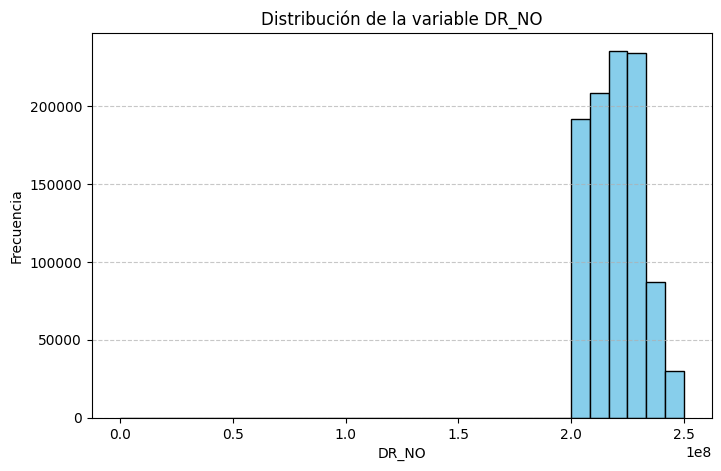

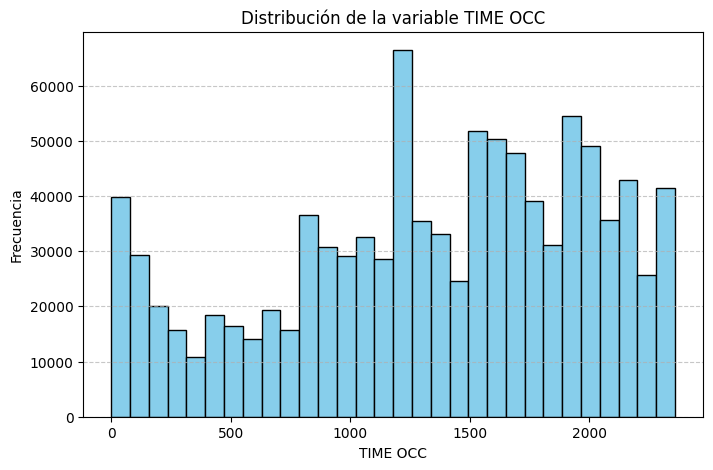

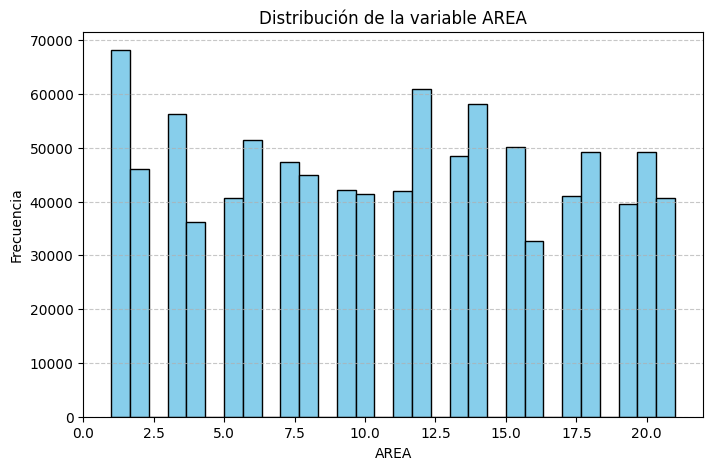

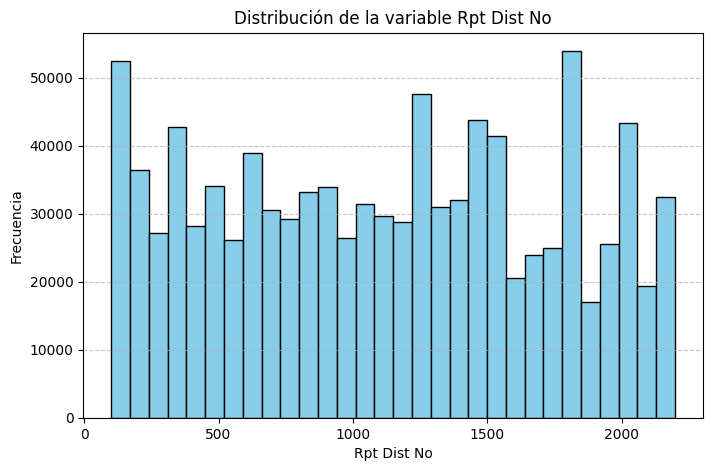

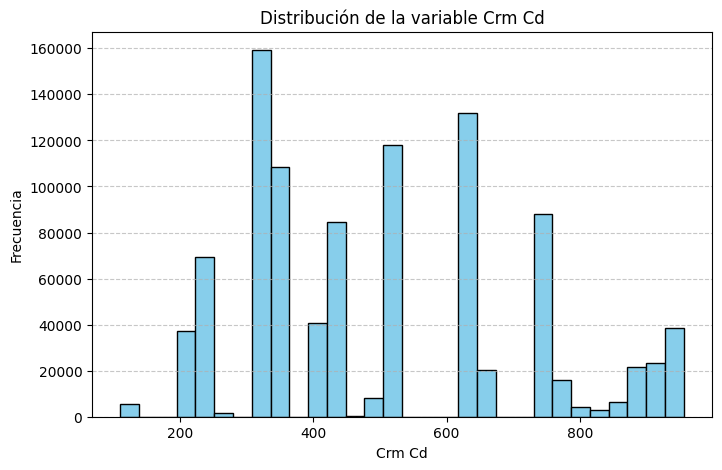

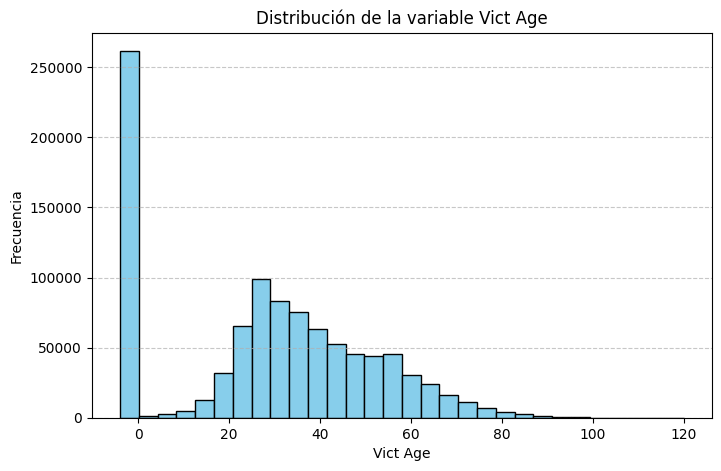

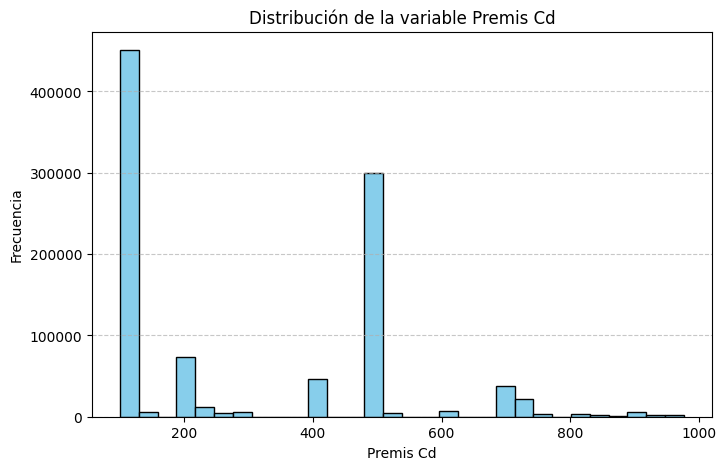

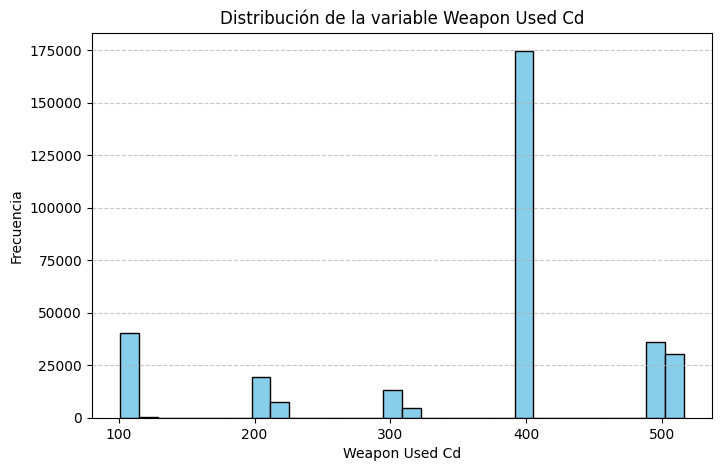

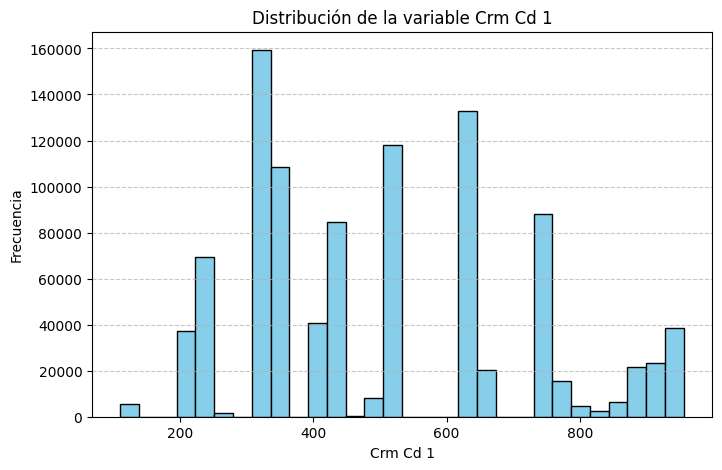

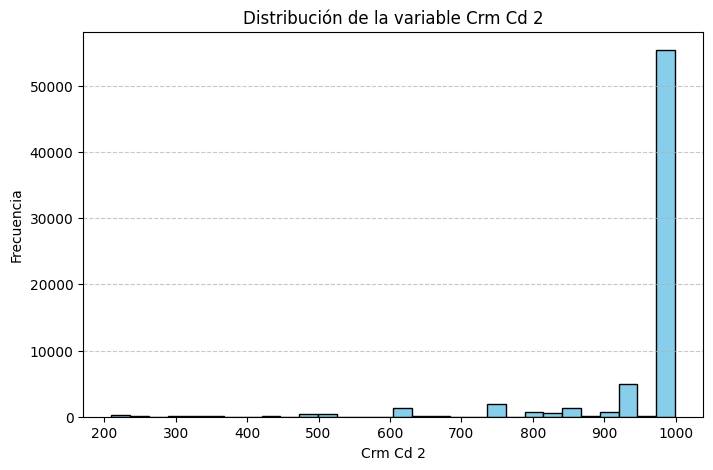

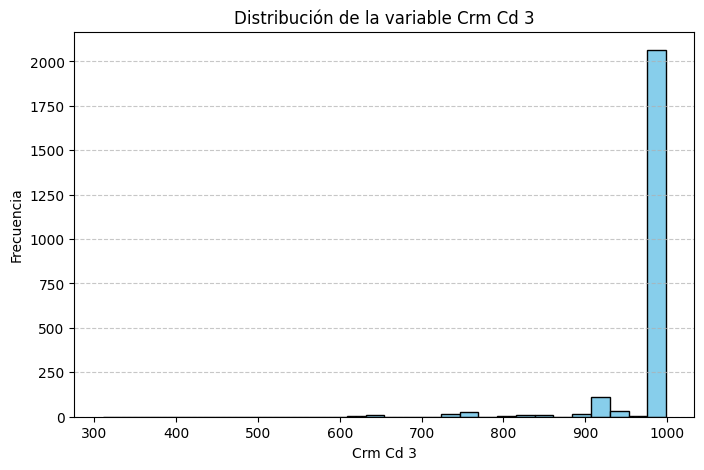

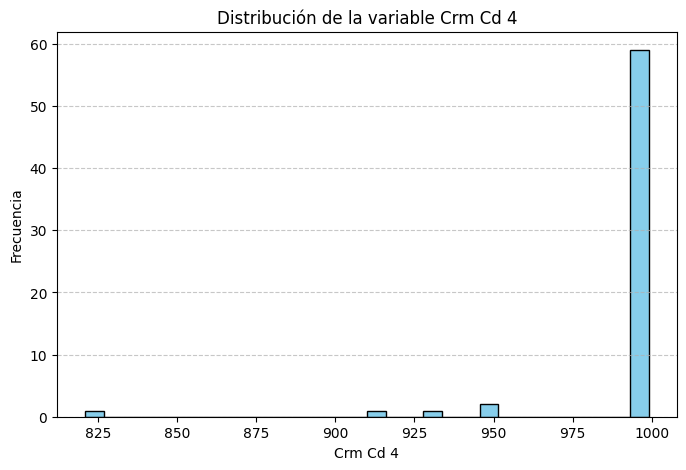

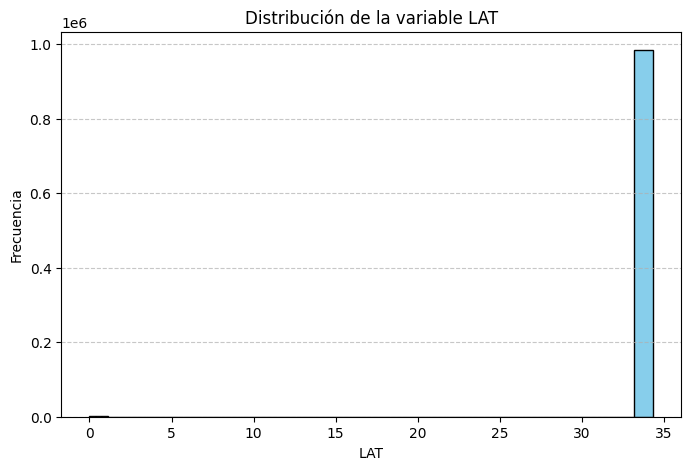

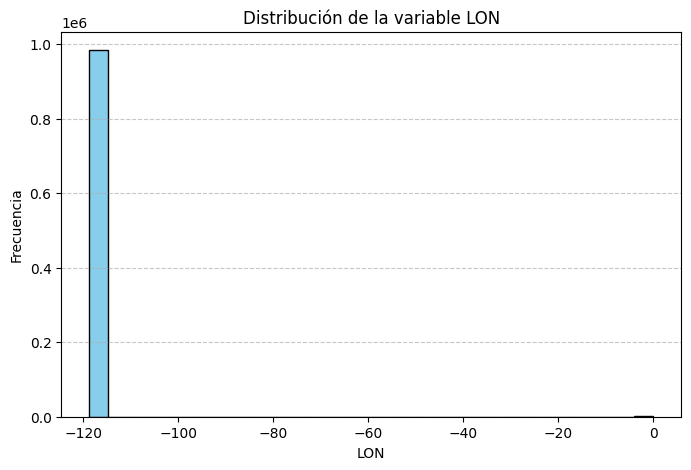

In [ ]:
# Seleccionar las columnas numéricas del DataFrame
numeric_columns = rs.select_dtypes(include=['int64', 'float64']).columns

# Crear un histograma para cada variable numérica
for col in numeric_columns:
    plt.figure(figsize=(8, 5))
    plt.hist(rs[col], bins=30, color='skyblue', edgecolor='black')
    plt.title(f"Distribución de la variable {col}")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

Los histogramas revelan características importantes de las distribuciones de las variables numéricas. Variables como "Rpt Dist No" y "Crm Cd 1" muestran distribuciones relativamente uniformes o multimodales, lo que podría sugerir diversidad en los datos. Por otro lado, variables como "Vict Age" y "Premis Cd" presentan concentraciones notables, lo que indica predominancia de ciertos valores. La latitud y longitud están restringidas a un rango muy estrecho, reflejando una localización geográfica específica. Finalmente, las variables de tiempos y gravedad exhiben patrones mas cercanos al cero por lo que los crimenes tienden mas a reportarse en esos tiempos cercanos al crimen.

#### Boxplots de variables numericas

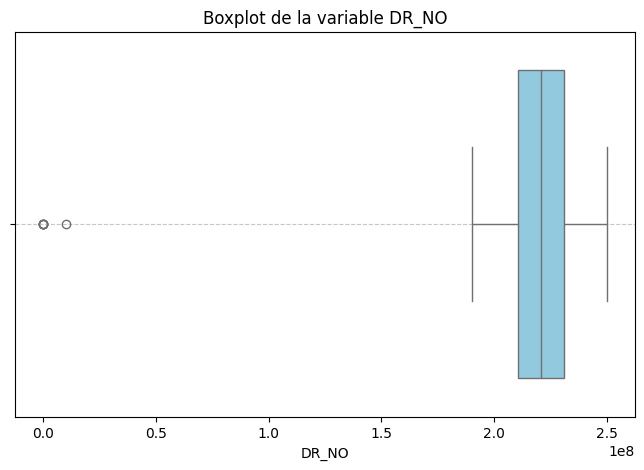

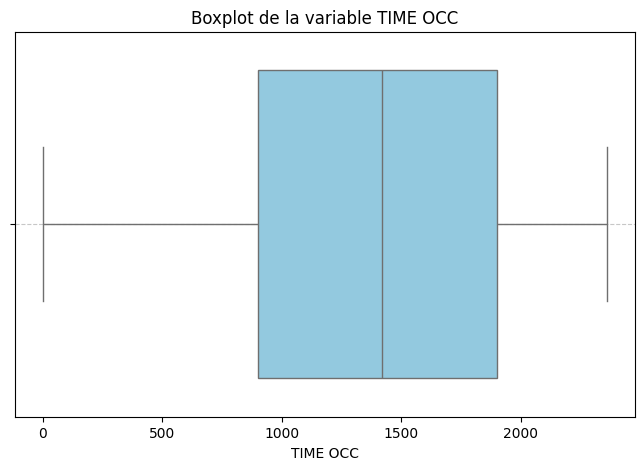

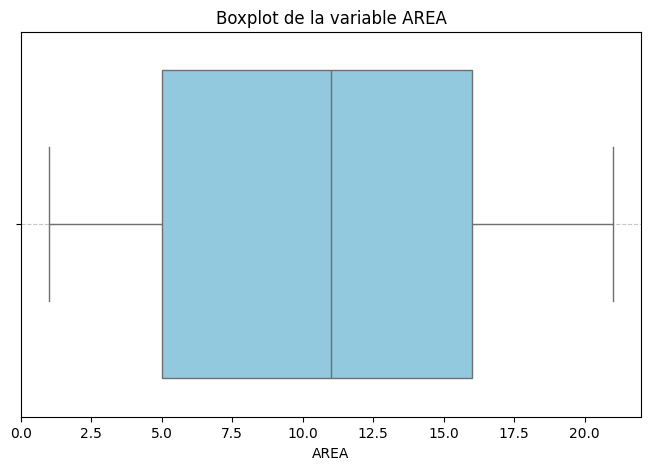

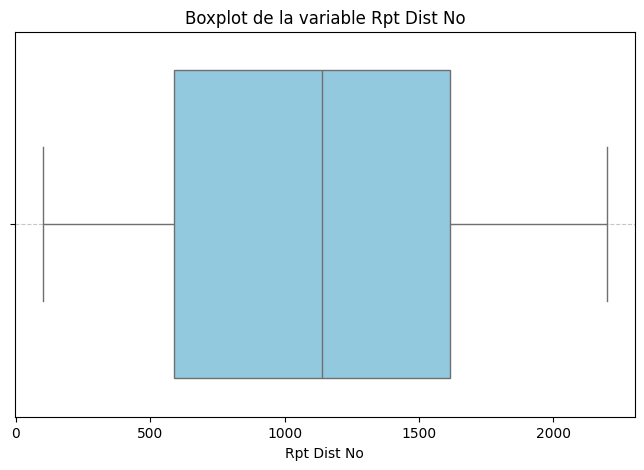

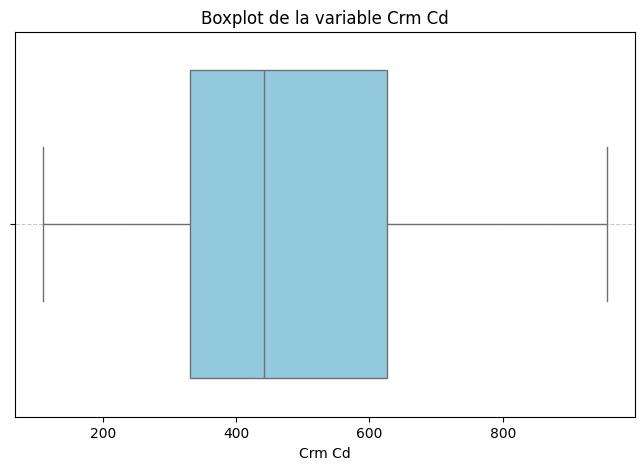

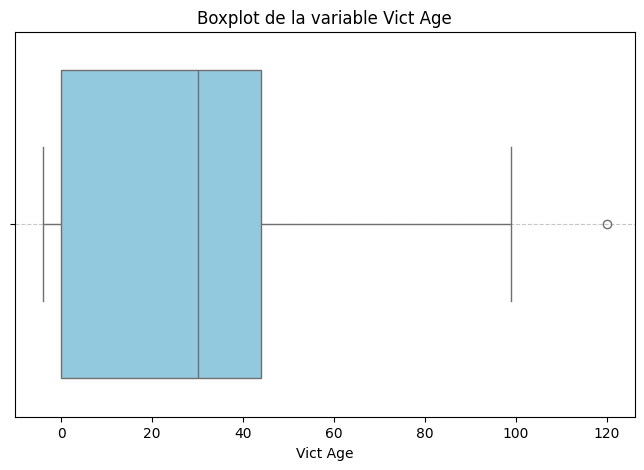

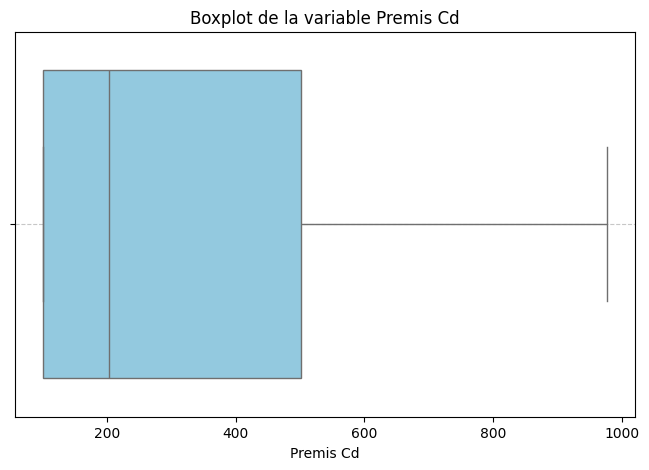

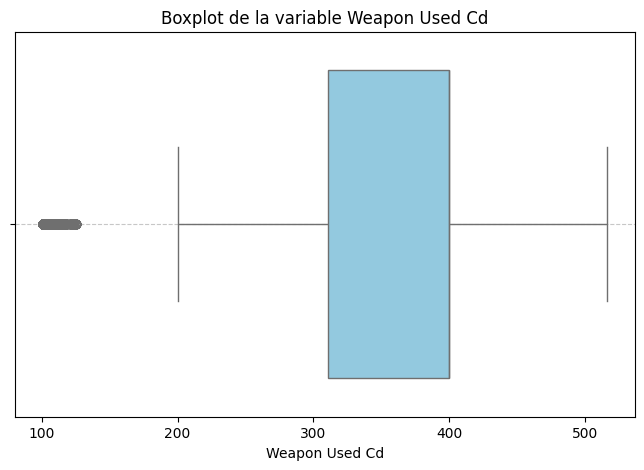

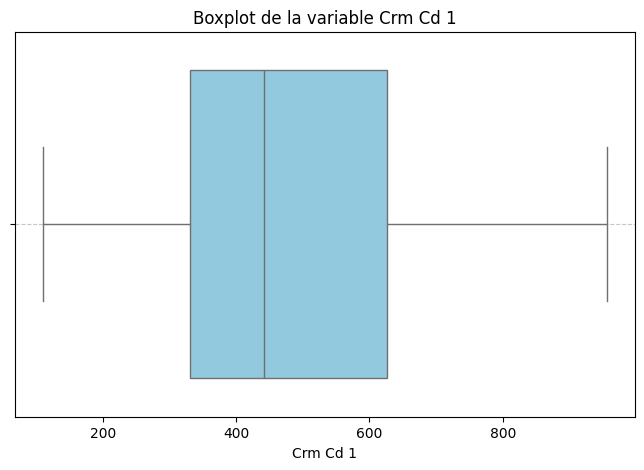

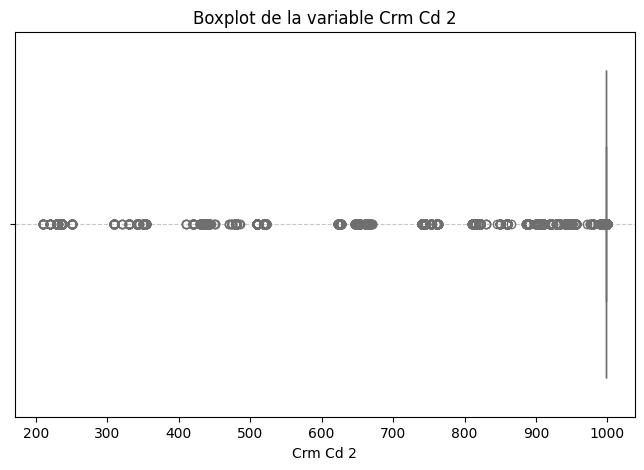

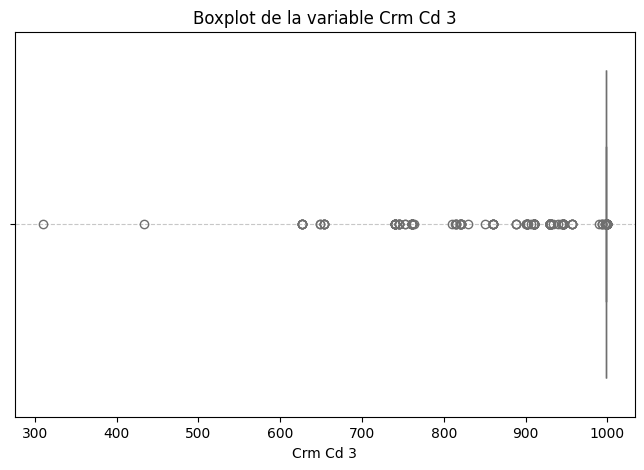

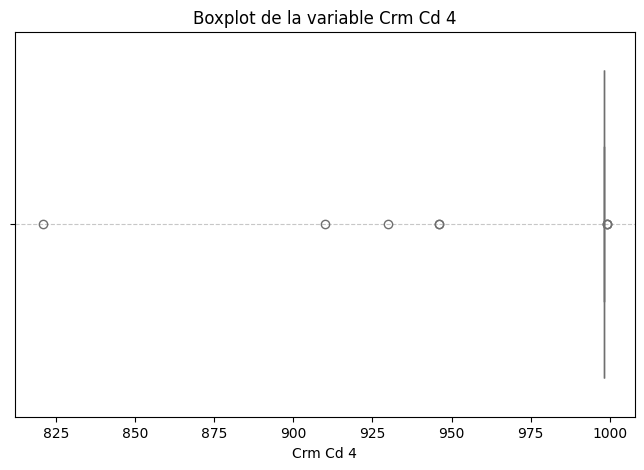

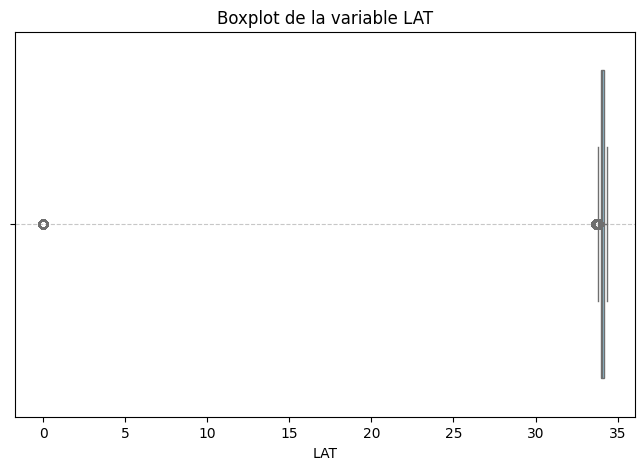

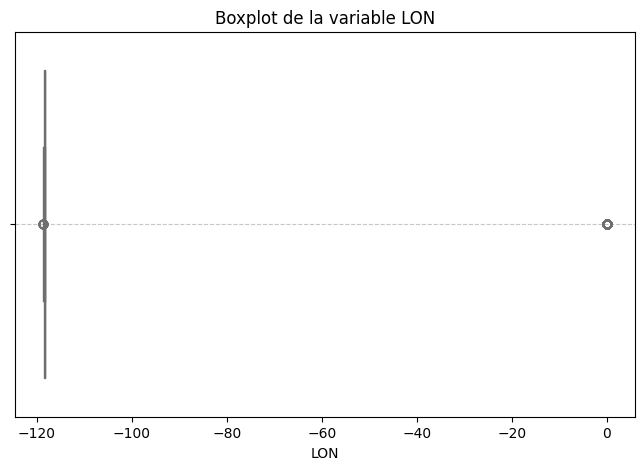

In [ ]:
# Crear un boxplot para cada columna numérica
for col in numeric_columns:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=rs[col], color='skyblue')
    plt.title(f"Boxplot de la variable {col}")
    plt.xlabel(col)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

Los boxplots de las variables numéricas del dataset revelan características importantes, destacando la presencia de outliers en varias variables. En particular, Vict Age muestra algunos valores extremos en edades superiores a 100 años. Las variables geográficas LAT y LON también incluyen puntos fuera del rango esperado, lo que podría indicar errores de registro. Estas observaciones resaltan la necesidad de tratar los outliers adecuadamente, ya que podrían distorsionar los resultados de los modelos predictivos. Este análisis sugiere aplicar técnicas para mitigar su impacto y mejorar la calidad del modelo.

### Matriz de correlación de pearson:

                DR_NO  TIME OCC  AREA  Rpt Dist No  Crm Cd  Vict Age  \
DR_NO            1.00     -0.00  0.04         0.04   -0.02     -0.06   
TIME OCC        -0.00      1.00  0.00         0.00    0.01     -0.03   
AREA             0.04      0.00  1.00         1.00   -0.01      0.02   
Rpt Dist No      0.04      0.00  1.00         1.00   -0.01      0.02   
Crm Cd          -0.02      0.01 -0.01        -0.01    1.00     -0.02   
Vict Age        -0.06     -0.03  0.02         0.02   -0.02      1.00   
Premis Cd        0.03     -0.06 -0.01        -0.01    0.12      0.19   
Weapon Used Cd   0.02     -0.01 -0.02        -0.02    0.37      0.08   
Crm Cd 1        -0.02      0.01 -0.01        -0.01    1.00     -0.02   
Crm Cd 2         0.03      0.01 -0.04        -0.04    0.00     -0.02   
Crm Cd 3         0.04     -0.00  0.03         0.03    0.12     -0.01   
Crm Cd 4         0.15     -0.03  0.16         0.16    0.04     -0.00   
LAT              0.05      0.00  0.02         0.02   -0.04     -

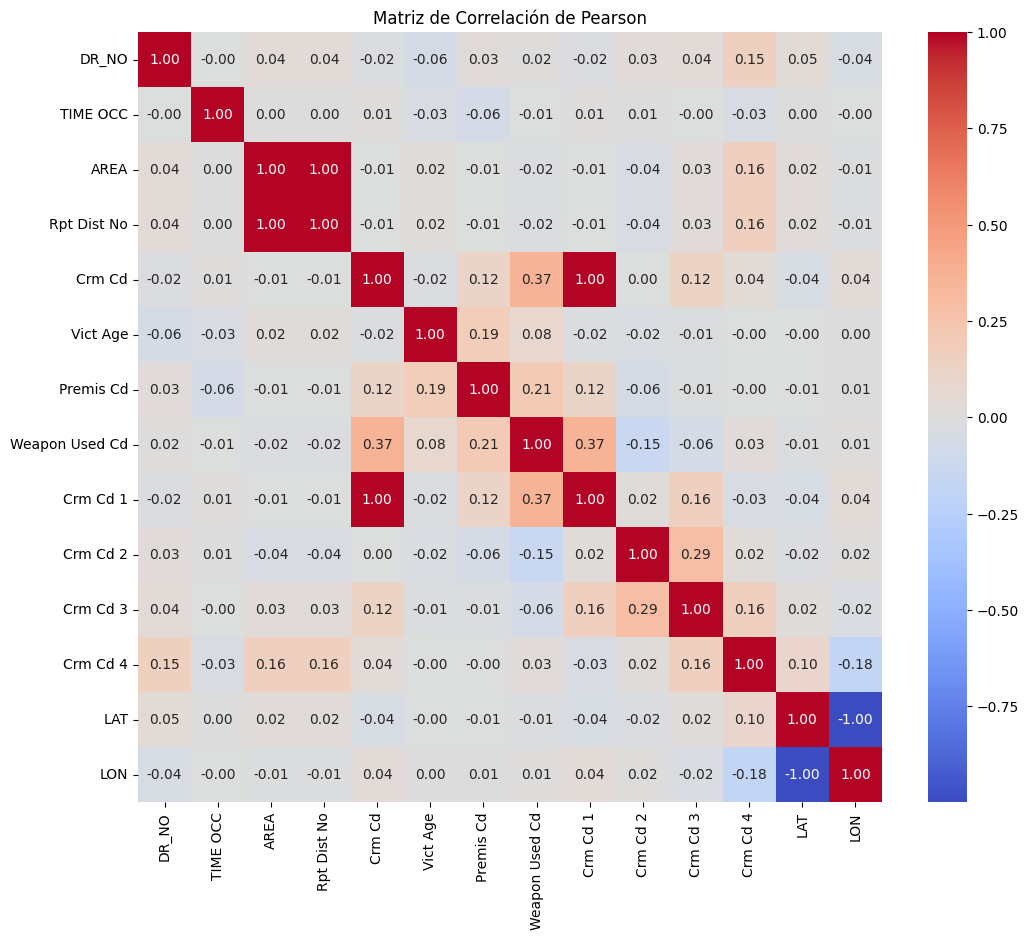

In [ ]:
# Filtrar solo las columnas numéricas
numeric_columns = rs.select_dtypes(include=['number'])

# Calcular la matriz de correlación de Pearson
correlation_matrix = numeric_columns.corr(method='pearson')

# Mostrar la matriz de correlación
print(correlation_matrix)

# Crear un mapa de calor para visualizar la matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación de Pearson')
plt.show()

Conclusiones de los resultados de la matriz:

Poca relación entre la mayoría de las variables: En general, las variables no están muy relacionadas entre sí (los valores de correlación están cerca de 0). Esto significa que cada una aporta información distinta y no se repiten mucho.

Latitud y longitud (LAT y LON): Estas dos variables están súper relacionadas (correlación de -1.00). Esto tiene sentido porque indican ubicaciones geográficas, y su relación refleja cómo están organizados los puntos en el mapa.

Códigos de crimen (Crm Cd):: Hay una conexión moderada entre algunos de estos códigos, como Crm Cd 1 y Crm Cd 4 (correlación de 0.37) o Crm Cd 2 y Crm Cd 3 (0.29). Esto podría significar que ciertos tipos de crímenes suelen ir de la mano o tienen algo en común.

Uso de armas (Weapon Used Cd): Está algo relacionado con Crm Cd 1 (0.37). Esto podría indicar que ciertos tipos de crímenes tienen más probabilidades de involucrar armas.

Edad de las víctimas (Vict Age) y lugar del incidente (Premis Cd): Hay una relación leve (0.19). Esto sugiere que la edad de las víctimas podría estar ligeramente conectada con el tipo de lugar donde ocurren los incidentes.

### A partir de la información sobre los valores nulos,el valor de cada parámetro y la matriz de correlacion para tomar decisiones se procede a realizar:

#### **1. Eliminar o Imputar Valores Nulos**

Las siguientes columnas contienen una cantidad significativa de valores nulos: Vict Sex, Vict Descent, Weapon Used Cd, Weapon Desc, Crm Cd 2, Crm Cd 3, Crm Cd 4 y Cross Street. A continuación, se describe el tratamiento propuesto para cada caso:

Vict Sex y Vict Descent Estas columnas son importantes porque existe una relación entre las características de la víctima y el estatus del crimen. Sin embargo, la alta cantidad de valores nulos podría dificultar su análisis. Propuesta: Imputar los valores nulos con una categoría como "Desconocido" para mantener la integridad de los datos y evitar la pérdida de información.

Weapon Used Cd y Weapon Desc Estas columnas indican si se usó algún arma en el crimen. Dado que un crimen puede ocurrir sin que se reporte un arma: Propuesta: Imputar los valores nulos con una categoría como "Sin arma" o equivalente.

Crm Cd 2, Crm Cd 3 y Crm Cd 4 Estas columnas representan crímenes secundarios asociados al principal (Crm Cd 1). Dado que suelen ser de menor relevancia y no aportan un valor significativo al análisis: Propuesta: Eliminar estas columnas para simplificar el modelo y reducir ruido.

Cross Street Esta columna contiene información sobre calles cercanas al incidente. Sin embargo, su relevancia es limitada, ya que la ubicación exacta (LOCATION) ya cubre esta información. Propuesta: Eliminar esta columna, ya que no aporta valor significativo al análisis.

Premis Cd, Premis Desc y Crm Cd 1 En estas columnas, la cantidad de valores nulos es mínima. Propuesta: Imputar los valores faltantes con la moda (en caso de datos categóricos) o asignar una categoría genérica como "No disponible" para mantener consistencia.

In [ ]:
# Asegurarnos de que 'Desconocido' esté incluido en las categorías antes de llenar los valores nulos
# Verificar si 'Desconocido' ya está en las categorías antes de intentar agregarlo
# Convertir las columnas a 'category' si aún no lo son
for col in ['Vict Sex', 'Vict Descent', 'Weapon Used Cd', 'Weapon Desc']:
    if not pd.api.types.is_categorical_dtype(rs[col]):
        rs[col] = rs[col].astype('category')
if 'Desconocido' not in rs['Vict Sex'].cat.categories:
    rs['Vict Sex'] = rs['Vict Sex'].astype('category').cat.add_categories(['Desconocido'])
if 'Desconocido' not in rs['Vict Descent'].cat.categories:
    rs['Vict Descent'] = rs['Vict Descent'].astype('category').cat.add_categories(['Desconocido'])
if 'Sin arma' not in rs['Weapon Used Cd'].cat.categories:
    rs['Weapon Used Cd'] = rs['Weapon Used Cd'].astype('category').cat.add_categories(['Sin arma'])
if 'Sin arma' not in rs['Weapon Desc'].cat.categories:
    rs['Weapon Desc'] = rs['Weapon Desc'].astype('category').cat.add_categories(['Sin arma'])


## Imputación para columnas con gran cantidad de nulos
rs['Vict Sex'].fillna('Desconocido', inplace=True)
rs['Vict Descent'].fillna('Desconocido', inplace=True)
rs['Weapon Used Cd'].fillna('Sin arma', inplace=True)
rs['Weapon Desc'].fillna('Sin arma', inplace=True)

## Imputación para crímenes menos serios (Crm Cd 2-4)
## Mejor eliminarlo en vez de imputarlo
rs['Crm Cd 2'].fillna('N/A', inplace=True)
rs['Crm Cd 3'].fillna('N/A', inplace=True)
rs['Crm Cd 4'].fillna('N/A', inplace=True)

## Imputación de premisa y código del crimen (mínimos valores nulos)
rs['Premis Cd'].fillna(rs['Premis Cd'].mode()[0], inplace=True) # Aca se utilizo la moda para rellenar los campos vacios y sustituir por el valor mas recurrente

'''
#Add 'No disponible' to the categories of 'Premis Desc'
if not pd.api.types.is_categorical_dtype(rs['Premis Desc']):
    #rs['Premis Desc'] = rs['Premis Desc'].astype('category')
if 'No disponible' not in rs['Premis Desc'].cat.categories:
    #rs['Premis Desc'] = rs['Premis Desc'].cat.add_categories(['No disponible'])
###

rs['Premis Desc'].fillna('No disponible', inplace=True) # este solo lo hariamos para premis cd
rs['Crm Cd 1'].fillna(rs['Crm Cd 1'].mode()[0], inplace=True)
rs['Premis Desc'].fillna('No disponible', inplace=True)
rs['Crm Cd 1'].fillna(rs['Crm Cd 1'].mode()[0], inplace=True)
'''


C:\Users\fabur\AppData\Local\Temp\ipykernel_12772\1500507104.py:5: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(rs[col]):
C:\Users\fabur\AppData\Local\Temp\ipykernel_12772\1500507104.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rs['Vict Sex'].fillna('Desconocido', inplace=True)
C:\Users\fabur\AppData\Local\Temp\ipykernel_12772\1500507104.py:19: FutureWarning: A value is trying

"\n#Add 'No disponible' to the categories of 'Premis Desc'\nif not pd.api.types.is_categorical_dtype(rs['Premis Desc']):\n    #rs['Premis Desc'] = rs['Premis Desc'].astype('category')\nif 'No disponible' not in rs['Premis Desc'].cat.categories:\n    #rs['Premis Desc'] = rs['Premis Desc'].cat.add_categories(['No disponible'])\n###\n\nrs['Premis Desc'].fillna('No disponible', inplace=True) # este solo lo hariamos para premis cd\nrs['Crm Cd 1'].fillna(rs['Crm Cd 1'].mode()[0], inplace=True)\nrs['Premis Desc'].fillna('No disponible', inplace=True)\nrs['Crm Cd 1'].fillna(rs['Crm Cd 1'].mode()[0], inplace=True)\n"

## **2.Eliminación de Parámetros Irrelevantes**


Se identificaron varias columnas que no aportan valor significativo al análisis o presentan redundancia. A continuación, se detalla el tratamiento propuesto:

**ID y duplicados de variables:**

**DR_NO**: Es un identificador único que no tiene relevancia analítica.
*Propuesta: *Eliminarlo.

**AREA NAME y AREA**: Ambas variables son equivalentes. Mientras AREA NAME es más descriptiva, AREA es más compacta y puede ser más útil para el análisis.
*Propuesta:* Seleccionar una de las dos, según las necesidades del análisis (se sugiere mantener AREA por ser más manejable).

**Fechas de reporte y ocurrencia**

**DATE Rptd y DATE OCC:** Ambas variables son importantes, pero su relación es más relevante que los valores individuales.
*Propuesta:* Crear una nueva variable que mida el tiempo transcurrido entre la fecha de ocurrencia y la fecha de reporte, y conservar solo esta.
Variables redundantes

**Premis Desc:** Es redundante con Premis Cd, ya que ambas describen el mismo concepto.
*Propuesta:*Eliminar Premis Desc y mantener Premis Cd.

**Weapon Desc:** Aporta la misma información que Weapon Used Cd, pero en formato textual.
*Propuesta:* Eliminar Weapon Desc y conservar Weapon Used Cd.

**Crm Cd 2, Crm Cd 3, Crm Cd 4 y Cross Street**
Estas columnas contienen información secundaria o complementaria a Crm Cd 1, pero no aportan valor adicional significativo y presentan un alto porcentaje de valores nulos.
*Propuesta:* Eliminarlas para simplificar el conjunto de datos.

**Crm Cd 1:** Se decide eliminar esta variable ya que contiene la misma información que la variable "Crm Cd" y además contiene 9 valores nulos.
        

In [ ]:
# Mostrar las columnas del DataFrame rs
print("Columnas en el DataFrame rs:")
print(rs.columns.tolist())

Columnas en el DataFrame rs:
['DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME', 'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes', 'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc', 'Weapon Used Cd', 'Weapon Desc', 'Status', 'Status Desc', 'Crm Cd 1', 'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'LOCATION', 'Cross Street', 'LAT', 'LON']


In [ ]:
## Eliminar identificador único y variables redundantes
rs.drop(columns=['DR_NO', 'AREA', 'Cross Street','Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4','Weapon Desc','Premis Desc', 'Status','Mocodes', 'Crm Cd 1' ], inplace=True)

In [ ]:
print("Shape of data orders:",rs.shape)
rs.info()

Shape of data orders: (986500, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 986500 entries, 0 to 986499
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   Date Rptd       986500 non-null  object  
 1   DATE OCC        986500 non-null  object  
 2   TIME OCC        986500 non-null  int64   
 3   AREA NAME       986500 non-null  category
 4   Rpt Dist No     986500 non-null  int64   
 5   Part 1-2        986500 non-null  category
 6   Crm Cd          986500 non-null  int64   
 7   Crm Cd Desc     986500 non-null  category
 8   Vict Age        986500 non-null  int64   
 9   Vict Sex        986500 non-null  category
 10  Vict Descent    986500 non-null  category
 11  Premis Cd       986500 non-null  float64 
 12  Weapon Used Cd  986500 non-null  category
 13  Status Desc     986500 non-null  category
 14  LOCATION        986500 non-null  object  
 15  LAT             986500 non-null  float64 
 16  LON

#### **3. Eliminacion de outliers**


In [ ]:
# Definir el rango intercuartílico (IQR) para identificar outliers
def eliminar_outliers_iqr(df, columnas):
    """
    Elimina los outliers de un DataFrame basado en el rango intercuartílico (IQR).

    Args:
        df (pd.DataFrame): DataFrame con los datos.
        columnas (list): Lista de columnas numéricas para analizar.

    Returns:
        pd.DataFrame: DataFrame sin outliers en las columnas especificadas.
    """
    df_limpio = df.copy()
    for col in columnas:
        Q1 = df[col].quantile(0.25)  # Primer cuartil
        Q3 = df[col].quantile(0.75)  # Tercer cuartil
        IQR = Q3 - Q1  # Rango intercuartílico

        # Rango aceptable para los datos
        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR

        # Filtrar valores dentro del rango
        df_limpio = df_limpio[(df_limpio[col] >= limite_inferior) & (df_limpio[col] <= limite_superior)]
    return df_limpio

# Lista de columnas numéricas para analizar
columnas_numericas = [
    "Vict Age",
    "LAT",
    "LON"
]

# Aplicar la función al DataFrame
rs_sin_outliers = eliminar_outliers_iqr(rs, columnas_numericas)

# Verificar reducción en los datos
print(f"Datos originales: {rs.shape}")
print(f"Datos después de eliminar outliers: {rs_sin_outliers.shape}")

Datos originales: (986500, 17)
Datos después de eliminar outliers: (956119, 17)


In [ ]:
rs=rs_sin_outliers

In [ ]:
print("Shape of data orders:",rs.shape)
rs.info()

Shape of data orders: (956119, 17)
<class 'pandas.core.frame.DataFrame'>
Index: 956119 entries, 0 to 986499
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   Date Rptd       956119 non-null  object  
 1   DATE OCC        956119 non-null  object  
 2   TIME OCC        956119 non-null  int64   
 3   AREA NAME       956119 non-null  category
 4   Rpt Dist No     956119 non-null  int64   
 5   Part 1-2        956119 non-null  category
 6   Crm Cd          956119 non-null  int64   
 7   Crm Cd Desc     956119 non-null  category
 8   Vict Age        956119 non-null  int64   
 9   Vict Sex        956119 non-null  category
 10  Vict Descent    956119 non-null  category
 11  Premis Cd       956119 non-null  float64 
 12  Weapon Used Cd  956119 non-null  category
 13  Status Desc     956119 non-null  category
 14  LOCATION        956119 non-null  object  
 15  LAT             956119 non-null  float64 
 16  LON     

El código elimina outliers en las columnas seleccionadas utilizando el rango intercuartílico (IQR). Define límites aceptables con 1.5 veces el IQR y filtra valores fuera de este rango. Este proceso redujo el tamaño del dataset, indicando que ciertos valores extremos se eliminaron, mejorando potencialmente la calidad de los datos para el análisis y modelado.

#### **4.Creación de Nuevas Variables**


Se crean dos columnas nuevas (DIAS_REPORTE_OCURRENCIA y HORAS_REPORTE_OCURRENCIA) que representan el tiempo entre el momento en que ocurrió el crimen y cuando fue reportado, lo cual puede ser útil para análisis posteriores.

Adicionalmente se crea otra variable nueva llamada "Momento del día".


In [ ]:
# Asegurarnos de que las columnas de fecha estén en formato datetime

rs['DATE OCC'] = pd.to_datetime(rs['DATE OCC'], errors='coerce')
rs['Date Rptd'] = pd.to_datetime(rs['Date Rptd'], errors='coerce')

# Crear una nueva columna que calcule la diferencia en días entre DATE Rptd y DATE OCC
rs['DIAS_REPORTE_OCURRENCIA'] = (rs['Date Rptd'] - rs['DATE OCC']).dt.days

# Si prefieres la diferencia en horas, puedes calcularla así:
rs['HORAS_REPORTE_OCURRENCIA'] = (rs['Date Rptd'] - rs['DATE OCC']).dt.total_seconds() / 3600


C:\Users\fabur\AppData\Local\Temp\ipykernel_12772\2113844127.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  rs['DATE OCC'] = pd.to_datetime(rs['DATE OCC'], errors='coerce')
C:\Users\fabur\AppData\Local\Temp\ipykernel_12772\2113844127.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  rs['Date Rptd'] = pd.to_datetime(rs['Date Rptd'], errors='coerce')


In [ ]:
# Verifica el formato de los valores en 'TIME OCC'
print(rs['TIME OCC'].head())  # Esto te ayudará a entender si está en formato militar o de otra manera

# Función de categorización ajustada para formato militar
def categorize_time(time):
    # Asegúrate de que el valor sea un número válido antes de categorizar
    if pd.isna(time):
        return 'Desconocido'

    # Convertir el valor a un número entero si es un string en formato militar (ej., "1400" -> 1400)
    time = int(time)

    if 0 <= time < 1200:
        return 'Mañana'
    elif 1200 <= time < 1800:
        return 'Tarde'
    elif 1800 <= time <= 2359:
        return 'Noche'
    else:
        return 'Desconocido'

# Aplicar la función de categorización a 'TIME OCC'
rs['Momento del Día'] = rs['TIME OCC'].apply(categorize_time)

# Revisa los resultados
print(rs['Momento del Día'].value_counts())


0    2130
1    1800
2    1700
3    2037
4    1200
Name: TIME OCC, dtype: int64
Momento del Día
Mañana    346375
Tarde     311226
Noche     298518
Name: count, dtype: int64


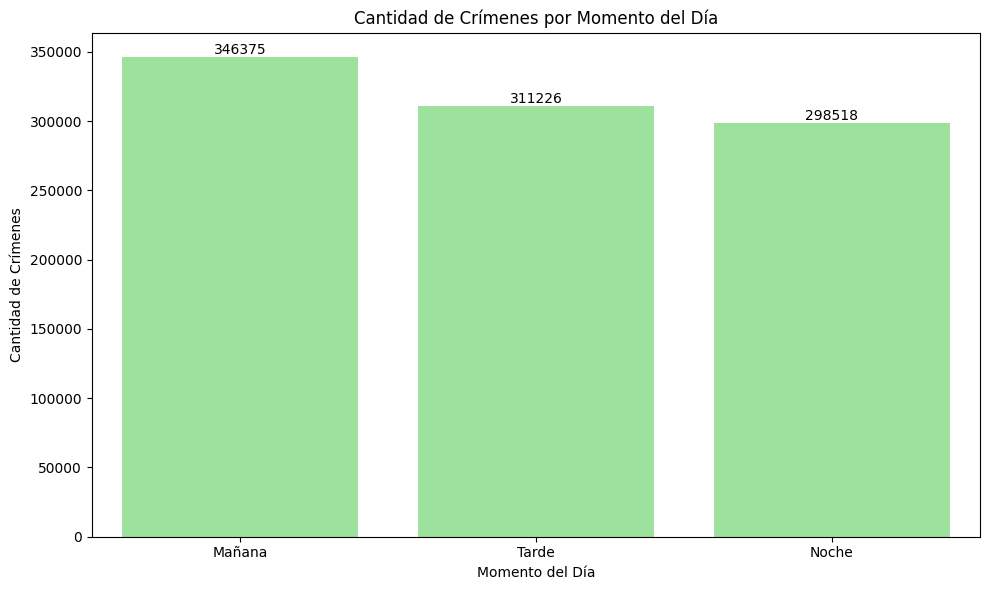

In [ ]:
# Contar la cantidad de ocurrencias por cada momento del día
conteo_momento_dia = rs['Momento del Día'].value_counts()

# Crear la gráfica de barras
plt.figure(figsize=(10, 6))
sns.barplot(x=conteo_momento_dia.index, y=conteo_momento_dia.values, color='lightgreen')  # Cambiado a 'color'

# Configurar el título y las etiquetas
plt.title('Cantidad de Crímenes por Momento del Día')
plt.xlabel('Momento del Día')
plt.ylabel('Cantidad de Crímenes')

# Mostrar los valores sobre las barras
for index, value in enumerate(conteo_momento_dia.values):
    plt.text(index, value, str(value), ha='center', va='bottom')

# Ajustar el layout
plt.tight_layout()

# Mostrar la gráfica
plt.show()

In [ ]:
rs['Momento del Día'] = rs['Momento del Día'].astype('category')
print("Shape of data orders:",rs.shape)
rs.info()

Shape of data orders: (956119, 20)
<class 'pandas.core.frame.DataFrame'>
Index: 956119 entries, 0 to 986499
Data columns (total 20 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   Date Rptd                 956119 non-null  datetime64[ns]
 1   DATE OCC                  956119 non-null  datetime64[ns]
 2   TIME OCC                  956119 non-null  int64         
 3   AREA NAME                 956119 non-null  category      
 4   Rpt Dist No               956119 non-null  int64         
 5   Part 1-2                  956119 non-null  category      
 6   Crm Cd                    956119 non-null  int64         
 7   Crm Cd Desc               956119 non-null  category      
 8   Vict Age                  956119 non-null  int64         
 9   Vict Sex                  956119 non-null  category      
 10  Vict Descent              956119 non-null  category      
 11  Premis Cd                 956119 no

**Variable rango etareo**

Se crea una nueva variable para definir los grupos de edad de las víctimas. La clasificación es la siguiente:

* 0 o desconosidos
* 1-12: Niños
* 13-19: Adolescentes
* 20-35: Jóvenes
* 36-55: Adultos
* 56 y más: Adultos mayores


In [ ]:
# Función para categorizar edades
def categorize_age(age):
    if pd.isna(age):
        return 'Desconocido'
    elif 0 < age <= 12:
        return 'Niño/a'
    elif 13 <= age <= 19:
        return 'Adolescente'
    elif 20 <= age <= 35:
        return 'Jóvenen'
    elif 36 <= age <= 55:
        return 'Adulto'
    elif age >= 56:
        return 'Adulto Mayor'
    else:
        return 'Desconocido o 0'

# Aplicar la función para crear una nueva columna con la categoría de edad
rs['Grupo de Edad Victimas'] = rs['Vict Age'].apply(categorize_age)

# Ver los resultados
print(rs['Grupo de Edad Victimas'].value_counts())

Grupo de Edad Victimas
Jóvenen            293335
Desconocido o 0    252425
Adulto             250826
Adulto Mayor       119721
Adolescente         31918
Niño/a               7894
Name: count, dtype: int64


In [ ]:
rs['Grupo de Edad Victimas'] = rs['Grupo de Edad Victimas'].astype('category')
print("Shape of data orders:",rs.shape)
rs.info()

Shape of data orders: (956119, 21)
<class 'pandas.core.frame.DataFrame'>
Index: 956119 entries, 0 to 986499
Data columns (total 21 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   Date Rptd                 956119 non-null  datetime64[ns]
 1   DATE OCC                  956119 non-null  datetime64[ns]
 2   TIME OCC                  956119 non-null  int64         
 3   AREA NAME                 956119 non-null  category      
 4   Rpt Dist No               956119 non-null  int64         
 5   Part 1-2                  956119 non-null  category      
 6   Crm Cd                    956119 non-null  int64         
 7   Crm Cd Desc               956119 non-null  category      
 8   Vict Age                  956119 non-null  int64         
 9   Vict Sex                  956119 non-null  category      
 10  Vict Descent              956119 non-null  category      
 11  Premis Cd                 956119 no

In [ ]:
rs.head()

,Date Rptd,DATE OCC,TIME OCC,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,Vict Age,Vict Sex,...,Premis Cd,Weapon Used Cd,Status Desc,LOCATION,LAT,LON,DIAS_REPORTE_OCURRENCIA,HORAS_REPORTE_OCURRENCIA,Momento del Día,Grupo de Edad Victimas
0,2020-03-01,2020-03-01,2130,Wilshire,784,1,510,VEHICLE - STOLEN,0,M,...,101.00,Sin arma,Adult Arrest,1900 S LONGWOOD AV,34.04,-118.35,0,0.00,Noche,Desconocido o 0
1,2020-02-09,2020-02-08,1800,Central,182,1,330,BURGLARY FROM VEHICLE,47,M,...,128.00,Sin arma,Invest Cont,1000 S FLOWER ST,34.04,-118.26,1,24.00,Noche,Adulto
2,2020-11-11,2020-11-04,1700,Southwest,356,1,480,BIKE - STOLEN,19,X,...,502.00,Sin arma,Invest Cont,1400 W 37TH ST,34.02,-118.30,7,168.00,Tarde,Adolescente
3,2023-05-10,2020-03-10,2037,Van Nuys,964,1,343,SHOPLIFTING-GRAND THEFT ($950.01 & OVER),19,M,...,405.00,Sin arma,Invest Cont,14000 RIVERSIDE DR,34.16,-118.44,1156,27744.00,Noche,Adolescente
4,2022-08-18,2020-08-17,1200,Hollywood,666,2,354,THEFT OF IDENTITY,28,M,...,102.00,Sin arma,Invest Cont,1900 TRANSIENT,34.09,-118.33,731,17544.00,Tarde,Jóvenen


C:\Users\fabur\AppData\Local\Temp\ipykernel_12772\3719238357.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=conteo_grupo_edad.index, y=conteo_grupo_edad.values, palette='Blues', order=conteo_grupo_edad.index)  # Asegúrate de usar el orden correcto


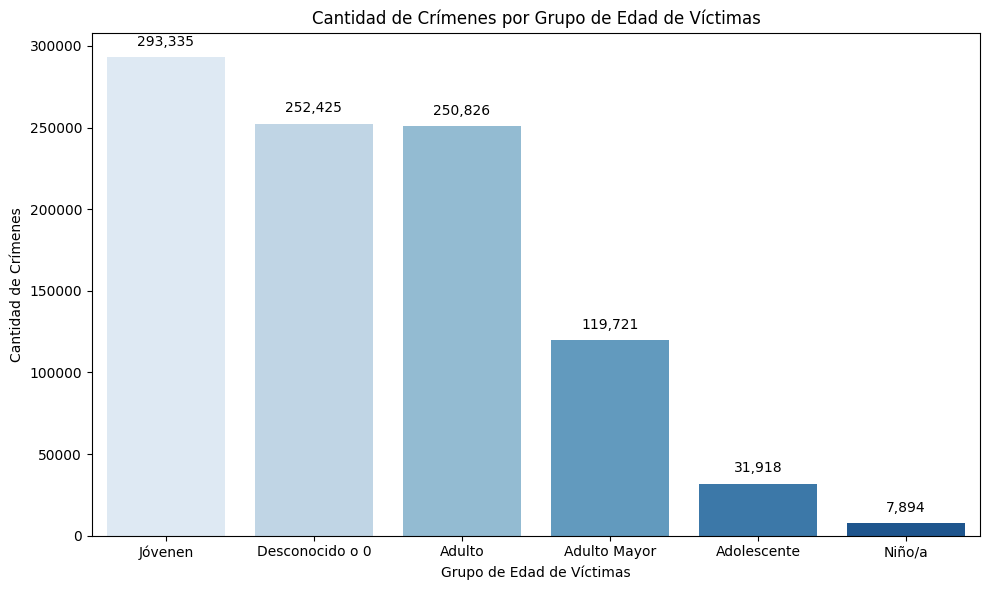

In [ ]:
# Contar la cantidad de ocurrencias por cada Grupo de Edad Victimas y ordenar de mayor a menor
conteo_grupo_edad = rs['Grupo de Edad Victimas'].value_counts().sort_values(ascending=False)

# Crear la gráfica de barras
plt.figure(figsize=(10, 6))
sns.barplot(x=conteo_grupo_edad.index, y=conteo_grupo_edad.values, palette='Blues', order=conteo_grupo_edad.index)  # Asegúrate de usar el orden correcto

# Configurar el título y las etiquetas
plt.title('Cantidad de Crímenes por Grupo de Edad de Víctimas')
plt.xlabel('Grupo de Edad de Víctimas')
plt.ylabel('Cantidad de Crímenes')

# Mostrar los valores sobre las barras
for index, value in enumerate(conteo_grupo_edad.values):
    plt.text(index, value + 5000, f'{value:,}', ha='center', va='bottom', fontsize=10, color='black')

# Ajustar el layout
plt.tight_layout()
plt.show()


La variable creada clasifica a las víctimas en grupos etarios: Joven, Adulto, Adulto Mayor, Adolescente, Niño/a y Desconocido o 0. La categoría "Desconocido o 0" se incluyó para manejar datos faltantes o inexactos en la edad, evitando eliminar registros que pueden ser relevantes para análisis. Esto asegura un enfoque inclusivo y robusto al preservar información potencialmente útil.

#### **4.Agrupación de Variables**

Se propone simplificar la clasificación de los crímenes mediante las siguientes acciones:

**Creación de una categoría binaria:** Utilizando la variable Part 1-2, se definirá una nueva columna que indique si el crimen es grave (Part 1) o menor (Part 2). Esto permitirá diferenciar rápidamente entre los dos niveles de severidad.

**Simplificación de categorías:** Los tipos de crímenes se agruparán en categorías amplias, combinando códigos específicos en grupos más generales. Esto reducirá la complejidad del análisis sin perder información relevante sobre los tipos de delitos.


In [ ]:
## Crear columna binaria para crímenes graves y menores usando Part 1-2
rs['Gravedad_Crimen'] = rs['Part 1-2'].apply(lambda x: 1 if x == 'Part 1' else 0)
rs.drop(columns=['Part 1-2'], inplace=True)


### Preparación y Preprocesamiento de Datos para Entrenamiento del Modelo

En este codigo empezamos la preparacion del dataset para los codigos de modelado. Creamos una copia del DataFrame original, separamos la variable objetivo (Status Desc). Y descartamos algunas variables que no nos estaban aportando al analisis como la latitud, longitud, Rpt Dist No y location porque estabamos teneiendo informacion reduntante sobre la informacion geografica de ocurrencia del crimen. Ademas descartamos la variable de la edad de la victima, debido a que hemos creado una variable que ya la incluye.

In [ ]:
# Crear una copia del DataFrame original
df = rs.copy()

# Separar la variable objetivo
y = df['Status Desc']
X = df.drop(columns=['Status Desc','Rpt Dist No' , 'LAT', 'LON', 'Vict Age', 'LOCATION', 'Date Rptd', 'DATE OCC','TIME OCC', 'Crm Cd'])

# Convertir columnas 'object' a 'category'
object_cols = X.select_dtypes(include=['object']).columns
X[object_cols] = X[object_cols].astype('category')

# Escalar las variables numéricas
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
scaler = MinMaxScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])



In [ ]:
X.head()

,AREA NAME,Crm Cd Desc,Vict Sex,Vict Descent,Premis Cd,Weapon Used Cd,DIAS_REPORTE_OCURRENCIA,HORAS_REPORTE_OCURRENCIA,Momento del Día,Grupo de Edad Victimas,Gravedad_Crimen
0,Wilshire,VEHICLE - STOLEN,M,O,0.00,Sin arma,0.00,0.00,Noche,Desconocido o 0,0.00
1,Central,BURGLARY FROM VEHICLE,M,O,0.03,Sin arma,0.00,0.00,Noche,Adulto,0.00
2,Southwest,BIKE - STOLEN,X,X,0.46,Sin arma,0.00,0.00,Tarde,Adolescente,0.00
3,Van Nuys,SHOPLIFTING-GRAND THEFT ($950.01 & OVER),M,O,0.35,Sin arma,0.66,0.66,Noche,Adolescente,0.00
4,Hollywood,THEFT OF IDENTITY,M,H,0.00,Sin arma,0.42,0.42,Tarde,Jóvenen,0.00


In [ ]:
y.head()

0    Adult Arrest
1     Invest Cont
2     Invest Cont
3     Invest Cont
4     Invest Cont
Name: Status Desc, dtype: category
Categories (6, object): ['Adult Arrest', 'Adult Other', 'Invest Cont', 'Juv Arrest', 'Juv Other', 'UNK']

## **Holdout** partición del dataset en x_train, x_test, y_train, y_test


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y,
random_state=semilla,
test_size=0.20,
shuffle=True)


In [ ]:
x_train

,AREA NAME,Crm Cd Desc,Vict Sex,Vict Descent,Premis Cd,Weapon Used Cd,DIAS_REPORTE_OCURRENCIA,HORAS_REPORTE_OCURRENCIA,Momento del Día,Grupo de Edad Victimas,Gravedad_Crimen
148272,Topanga,INTIMATE PARTNER - SIMPLE ASSAULT,F,W,0.46,400.00,0.00,0.00,Mañana,Adulto,0.00
583425,Southeast,ROBBERY,F,B,0.00,102.00,0.00,0.00,Tarde,Jóvenen,0.00
726256,Central,"THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LI...",M,W,0.46,Sin arma,0.00,0.00,Tarde,Adulto Mayor,0.00
129709,Pacific,"EMBEZZLEMENT, GRAND THEFT ($950.01 & OVER)",Desconocido,Desconocido,0.12,Sin arma,0.05,0.05,Tarde,Desconocido o 0,0.00
879741,West Valley,VEHICLE - STOLEN,Desconocido,Desconocido,0.00,Sin arma,0.00,0.00,Mañana,Desconocido o 0,0.00
...,...,...,...,...,...,...,...,...,...,...,...
199292,Central,"BUNCO, GRAND THEFT",M,A,0.12,Sin arma,0.85,0.85,Tarde,Desconocido o 0,0.00
18357,Foothill,BATTERY - SIMPLE ASSAULT,M,W,0.00,400.00,0.00,0.00,Mañana,Adulto,0.00
29033,Wilshire,"THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LI...",Desconocido,Desconocido,0.12,Sin arma,0.00,0.00,Noche,Desconocido o 0,0.00
287948,Northeast,THEFT PLAIN - PETTY ($950 & UNDER),M,W,0.46,Sin arma,0.00,0.00,Mañana,Adulto,0.00


In [ ]:
print("Cantidad de observaciones total: {0}".format(len(X)))
print("Cantidad de observaciones en train: {0}".format(len(x_train)))
print("Cantidad de observaciones en test: {0}".format(len(x_test)))

Cantidad de observaciones total: 956119
Cantidad de observaciones en train: 764895
Cantidad de observaciones en test: 191224


En este caso, el conjunto de datos total consta de 956,119 observaciones. De estas, el 80% (764,895 observaciones) se asignaron al conjunto de entrenamiento (train), que se utilizará para ajustar los modelos predictivos. El 20% restante (191,224 observaciones) conforma el conjunto de prueba (test), reservado para evaluar la precisión del modelo y su capacidad de generalización a nuevos datos. Este enfoque asegura una adecuada división entre aprendizaje y evaluación.

In [ ]:
shape_x_train = x_train.shape
print (shape_x_train)

(764895, 11)


In [ ]:
shape_x_test= x_test.shape
print(shape_x_test)

(191224, 11)


In [ ]:
type(y_train)

pandas.core.series.Series

In [ ]:
y_train

148272    Adult Other
583425    Invest Cont
726256    Invest Cont
129709    Invest Cont
879741    Invest Cont
             ...     
199292    Invest Cont
18357     Invest Cont
29033     Adult Other
287948    Invest Cont
798723    Invest Cont
Name: Status Desc, Length: 764895, dtype: category
Categories (6, object): ['Adult Arrest', 'Adult Other', 'Invest Cont', 'Juv Arrest', 'Juv Other', 'UNK']

In [ ]:
y_train.shape

(764895,)

In [ ]:
y_test

168428    Adult Other
926381    Invest Cont
570352    Invest Cont
821294    Adult Other
267822    Invest Cont
             ...     
695021    Invest Cont
107857    Invest Cont
313735    Invest Cont
802341    Invest Cont
212015    Invest Cont
Name: Status Desc, Length: 191224, dtype: category
Categories (6, object): ['Adult Arrest', 'Adult Other', 'Invest Cont', 'Juv Arrest', 'Juv Other', 'UNK']

## Transformaciones con OneHot Encoder ##

In [ ]:
# Revisar la forma de y_train y y_test
print("Forma de y_train:", y_train.shape)
print("Forma de y_test:", y_test.shape)


Forma de y_train: (764895,)
Forma de y_test: (191224,)


In [ ]:
y_train

148272    Adult Other
583425    Invest Cont
726256    Invest Cont
129709    Invest Cont
879741    Invest Cont
             ...     
199292    Invest Cont
18357     Invest Cont
29033     Adult Other
287948    Invest Cont
798723    Invest Cont
Name: Status Desc, Length: 764895, dtype: category
Categories (6, object): ['Adult Arrest', 'Adult Other', 'Invest Cont', 'Juv Arrest', 'Juv Other', 'UNK']

In [ ]:
# 1. Codificar etiquetas categóricas a valores numéricos con LabelEncoder
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)  # Codificar y_train
y_test_encoded = encoder.transform(y_test)       # Usar el mismo encoder para y_test

# 2. Convertir etiquetas numéricas a formato one-hot encoding
y_train_one_hot = to_categorical(y_train_encoded)
y_test_one_hot = to_categorical(y_test_encoded)

# Validar las formas de las etiquetas
print("Forma de y_train_one_hot:", y_train_one_hot.shape)
print("Forma de y_test_one_hot:", y_test_one_hot.shape)


Forma de y_train_one_hot: (764895, 6)
Forma de y_test_one_hot: (191224, 6)


En este proceso, se transforman las etiquetas categóricas de las variables objetivo (y_train y y_test) en un formato adecuado para modelos de aprendizaje profundo. Primero, se utiliza LabelEncoder para convertir las categorías de texto en valores numéricos únicos, facilitando el procesamiento computacional. Luego, con to_categorical, se transforman estos valores numéricos en un formato one-hot encoding, que genera vectores binarios donde un único elemento indica la clase correspondiente, mientras el resto son ceros. Este formato es necesario para modelos que utilizan activaciones como softmax. Finalmente, se validan las dimensiones de las etiquetas transformadas para asegurar consistencia y preparación adecuada para el entrenamiento.

In [ ]:
# Identificar columnas categóricas en x_train
categ_cols = x_train.select_dtypes(include=['object', 'category']).columns

# Convertir características categóricas a one-hot encoding
x_train_encoded = pd.get_dummies(x_train, columns=categ_cols, drop_first=True)
x_test_encoded = pd.get_dummies(x_test, columns=categ_cols, drop_first=True)

# Validar las formas de x_train y x_test después de codificación
print("Forma de x_train_encoded:", x_train_encoded.shape)
print("Forma de x_test_encoded:", x_test_encoded.shape)

# Asegurar que las columnas en x_train y x_test sean consistentes
x_test_encoded = x_test_encoded.reindex(columns=x_train_encoded.columns, fill_value=0)


Forma de x_train_encoded: (764895, 274)
Forma de x_test_encoded: (191224, 274)


Este código transforma las variables categóricas de los conjuntos de entrenamiento (x_train) y prueba (x_test) en un formato numérico mediante el método de one-hot encoding. Primero, se identifican las columnas categóricas en x_train y se aplica pd.get_dummies, generando nuevas columnas binarias para cada categoría única (excluyendo la primera categoría con drop_first=True, para evitar multicolinealidad). Tras la transformación, se valida que las columnas en ambos conjuntos sean consistentes al reindexar x_test_encoded según las columnas de x_train_encoded, llenando los valores faltantes con ceros. Esto asegura que los conjuntos de datos estén preparados para modelos que no aceptan valores categóricos directamente.

In [ ]:
# Dividir el conjunto de entrenamiento (80% de x_train_encoded) en entrenamiento y validación
x_train_final, x_val, y_train_final, y_val = train_test_split(
    x_train_encoded, y_train_one_hot, test_size=0.20, random_state=42, shuffle=True
)

# Validar las formas de los conjuntos
print("Forma de x_train_final:", x_train_final.shape)  # Entrenamiento final
print("Forma de x_val:", x_val.shape)                 # Validación
print("Forma de x_test_encoded:", x_test_encoded.shape)  # Conjunto de prueba
print("Forma de y_train_final:", y_train_final.shape)  # Etiquetas de entrenamiento
print("Forma de y_val:", y_val.shape)                 # Etiquetas de validación
print("Forma de y_test_one_hot:", y_test_one_hot.shape)  # Etiquetas de prueba


Forma de x_train_final: (611916, 274)
Forma de x_val: (152979, 274)
Forma de x_test_encoded: (191224, 274)
Forma de y_train_final: (611916, 6)
Forma de y_val: (152979, 6)
Forma de y_test_one_hot: (191224, 6)



Los datos se organizaron en conjuntos de entrenamiento, validación y prueba de la siguiente manera:

* x_train_final: Contiene 611,916 registros con 255 variables predictoras, utilizado para entrenar el modelo.

* x_val: Incluye 152,979 registros para validación, también con 255 variables predictoras, representando un 20% típico del conjunto de entrenamiento.

* x_test_encoded: Conjunto de pruebas formado por 191,224 registros con 255 variables predictoras, empleado para evaluar el modelo final.

* y_train_final: 611,916 etiquetas correspondientes al conjunto de entrenamiento, representadas en formato one-hot encoding para 6 clases posibles.

* y_val: 152,979 etiquetas asociadas al conjunto de validación.

* y_test_one_hot: 191,224 etiquetas en formato one-hot encoding para evaluar el modelo final, también con 6 clases posibles.

Esta división asegura un buen balance entre los conjuntos, permitiendo entrenar, validar y evaluar el modelo.

## Definimos el modelo incial

El modelo inicial está diseñado para abordar un problema de clasificación multiclase utilizando una arquitectura simple pero efectiva. Este modelo tiene una capa de entrada que recibe como dimensiones el número de características en los datos (input_dim = x_train_final.shape[1]) y una capa de salida que genera probabilidades para cada clase objetivo tras la codificación one-hot (nclasses = y_train_final.shape[1]). Entre la entrada y la salida, el modelo cuenta con dos capas densas: la primera con 64 neuronas y la segunda con 32, ambas con activación ReLU. Para la salida, se utiliza una capa densa con un número de neuronas igual a las clases y activación Softmax.

En términos de regularización, se implementaron dos técnicas clave. La primera es Dropout, que se aplica en la primera capa oculta con una tasa del 50%, lo que ayuda a reducir el sobreajuste al apagar aleatoriamente la mitad de las neuronas durante el entrenamiento. La segunda técnica es Early Stopping, configurada para monitorear la pérdida de validación (val_loss). Si la pérdida no mejora durante cinco épocas consecutivas, el entrenamiento se detiene automáticamente, restaurando los mejores pesos alcanzados durante el proceso. Además, se utiliza TensorBoard para registrar métricas del entrenamiento y validación, lo que facilita el monitoreo visual del progreso del modelo.

El modelo utiliza el optimizador Adam con una tasa de aprendizaje inicial fija de 0.001, junto con la función de pérdida categorical_crossentropy, adecuada para problemas de clasificación multiclase. El entrenamiento se realiza en mini-lotes (batch_size = 16) durante un máximo de 25 épocas, utilizando la precisión (accuracy) como métrica de evaluación.

Aunque el modelo incluye mecanismos básicos para evitar el sobreajuste, como Dropout y Early Stopping, su arquitectura es relativamente sencilla y podría no ser suficiente para capturar relaciones complejas en los datos. Además, no compensa explícitamente el desbalance de clases, lo que podría sesgar las predicciones hacia las clases mayoritarias. Tampoco incluye técnicas avanzadas como regularización L2, reducción de la dimensionalidad mediante PCA, o funciones de pérdida adaptadas al desbalance de clases, como Focal Loss, que podrían mejorar significativamente su rendimiento.

Para mejorar este modelo, se podrían implementar varios ajustes. Una opción sería aumentar su complejidad agregando más capas densas, activaciones avanzadas como tanh o Leaky ReLU, o normalización por lotes (Batch Normalization). También sería beneficioso compensar el desbalance de clases mediante el uso de pesos por clase o la generación de datos sintéticos con técnicas como SMOTE. Finalmente, la adición de regularización L2 o el uso de una tasa de aprendizaje dinámica podría ayudar a mejorar la estabilidad del entrenamiento y evitar el sobreajuste. Si deseas implementar alguna de estas mejoras, no dudes en indicármelo.

In [ ]:
# Dimensiones de entrada y número de clases
input_dim = x_train_final.shape[1]  # Usar x_train_final tras la división en validación
nclasses = y_train_final.shape[1]   # Usar y_train_final tras la conversión a one-hot

# Crear el modelo secuencial
model = Sequential()
model.add(Dense(64, input_shape=(input_dim,), activation='relu'))
model.add(Dropout(0.5))  # Regularización para evitar overfitting
model.add(Dense(32, activation='relu'))  # Segunda capa densa
model.add(Dense(nclasses, activation='softmax'))  # Capa de salida con softmax

# Resumen del modelo
model.summary()

# Graficar el modelo (opcional)
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, to_file='model_structure.png')



C:\Users\fabur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        17,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,878 (77.65 KB)

 Trainable params: 19,878 (77.65 KB)

 Non-trainable params: 0 (0.00 B)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [ ]:
learn_rate = 0.001
opt = Adam(learning_rate= learn_rate)

In [ ]:
model.compile(optimizer= opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
batch_size = 16
epochs = 25
VERBOSE = 1

In [ ]:
# Google Colab
COLAB = True

# TB callbacks
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
TBLOGDIRS = {'Status Desc': 'logs/status/tb_'}
TBLOGDIRS = {k:v+current_time for (k,v) in TBLOGDIRS.items()}
tensorboard = TensorBoard(TBLOGDIRS['Status Desc'], histogram_freq = 1)

In [ ]:
# Configurar EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Métrica a monitorear (val_loss o val_accuracy)
    patience=5,          # Número de épocas sin mejora antes de detener el entrenamiento
    restore_best_weights=True  # Restaurar los pesos del modelo con el mejor rendimiento
)

In [ ]:


# Entrenar el modelo
history = model.fit(
    x_train_final, y_train_final,  # Datos de entrenamiento
    validation_data=(x_val, y_val),  # Datos de validación
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[
        TensorBoard(log_dir=TBLOGDIRS['Status Desc'], histogram_freq=1),
        early_stopping
    ],  # Añadir EarlyStopping
    verbose=VERBOSE
)


Epoch 1/25
38245/38245 ━━━━━━━━━━━━━━━━━━━━ 79s 2ms/step - accuracy: 0.8089 - loss: 0.5342 - val_accuracy: 0.8166 - val_loss: 0.5039
Epoch 2/25
38245/38245 ━━━━━━━━━━━━━━━━━━━━ 68s 2ms/step - accuracy: 0.8150 - loss: 0.5082 - val_accuracy: 0.8162 - val_loss: 0.5025
Epoch 3/25
38245/38245 ━━━━━━━━━━━━━━━━━━━━ 84s 2ms/step - accuracy: 0.8157 - loss: 0.5057 - val_accuracy: 0.8185 - val_loss: 0.5013
Epoch 4/25
38245/38245 ━━━━━━━━━━━━━━━━━━━━ 73s 2ms/step - accuracy: 0.8172 - loss: 0.5039 - val_accuracy: 0.8186 - val_loss: 0.4986
Epoch 5/25
38245/38245 ━━━━━━━━━━━━━━━━━━━━ 71s 2ms/step - accuracy: 0.8165 - loss: 0.5043 - val_accuracy: 0.8191 - val_loss: 0.4982
Epoch 6/25
38245/38245 ━━━━━━━━━━━━━━━━━━━━ 71s 2ms/step - accuracy: 0.8167 - loss: 0.5035 - val_accuracy: 0.8185 - val_loss: 0.4999
Epoch 7/25
38245/38245 ━━━━━━━━━━━━━━━━━━━━ 71s 2ms/step - accuracy: 0.8170 - loss: 0.5022 - val_accuracy: 0.8180 - val_loss: 0.4983
Epoch 8/25
38245/38245 ━━━━━━━━━━━━━━━━━━━━ 71s 2ms/step - accuracy: 

In [ ]:
if COLAB:
  # Reload TB
  %reload_ext tensorboard

  # Colab: Init TB
  %tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 26092), started 13 days, 23:28:58 ago. (Use '!kill 26092' to kill it.)

In [ ]:
y_pred = model.predict(x_test_encoded)
y_pred.shape

5976/5976 ━━━━━━━━━━━━━━━━━━━━ 6s 957us/step


(191224, 6)

In [ ]:
y_pred

array([[6.48322776e-02, 2.64561594e-01, 6.60789132e-01, 3.38201295e-03,
        6.43500360e-03, 1.47279758e-13],
       [1.57732125e-02, 3.94995548e-02, 9.44508851e-01, 1.11499394e-04,
        1.06849817e-04, 3.15649281e-13],
       [4.27704491e-02, 1.15391523e-01, 8.39858711e-01, 1.19201851e-03,
        7.87287951e-04, 1.63630351e-12],
       ...,
       [3.37597460e-01, 1.06684364e-01, 4.73975778e-01, 7.13480636e-02,
        1.03943497e-02, 1.63331277e-15],
       [3.40867527e-02, 1.14618056e-01, 8.50641131e-01, 4.07696411e-04,
        2.46278476e-04, 2.07748992e-11],
       [6.64530322e-02, 2.63474863e-02, 9.05794680e-01, 1.04289374e-03,
        3.61848535e-04, 9.58555318e-11]], dtype=float32)

In [ ]:
y_test_one_hot.shape

(191224, 6)

In [ ]:
argmax_ytest = np.argmax(y_test_one_hot, axis=1)

In [ ]:
y_pred_classes = np.argmax(y_pred, axis=1)
print("Primeras clases predichas:", y_pred_classes[:10])
print("Distribución de clases predichas:", np.unique(y_pred_classes, return_counts=True))


Primeras clases predichas: [2 2 2 2 2 2 2 2 2 2]
Distribución de clases predichas: (array([0, 1, 2]), array([  1768,  15036, 174420]))


In [ ]:
mf = confusion_matrix(argmax_ytest, y_pred_classes)
print(mf)


[[   942   3439  12029      0      0      0]
 [   410   7248  13196      0      0      0]
 [   383   4266 148326      0      0      0]
 [    26     38    583      0      0      0]
 [     7     45    284      0      0      0]
 [     0      0      2      0      0      0]]


Text(0.5, 427.9555555555555, 'Etiqueta predicha')

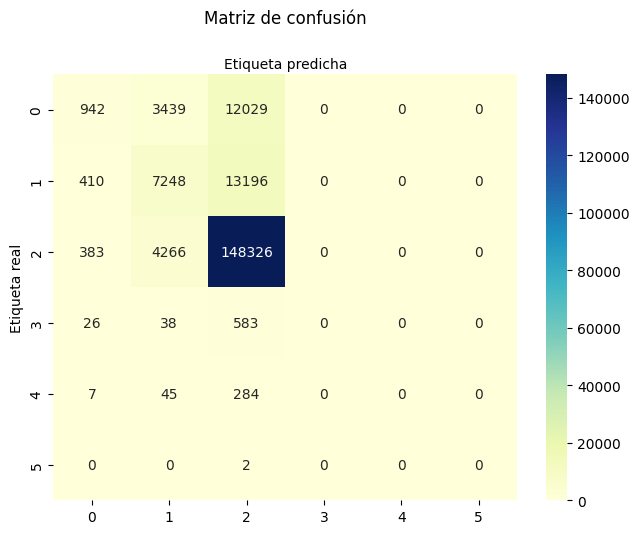

In [ ]:
class_names=[0,1,2,3,4,5] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(mf), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Matriz de confusión', y=1.1)
plt.ylabel('Etiqueta real')
plt.xlabel('Etiqueta predicha')

In [ ]:
print("Forma de y_test:", y_test_one_hot.shape)
print("Forma de y_pred:", y_pred.shape)


Forma de y_test: (191224, 6)
Forma de y_pred: (191224, 6)


In [ ]:

print(classification_report(np.argmax(y_test_one_hot, axis = 1), np.argmax(y_pred, axis = 1), digits = 6, labels = [0,1,2,3,4]))


              precision    recall  f1-score   support

           0   0.532805  0.057404  0.103642     16410
           1   0.482043  0.347559  0.403901     20854
           2   0.850396  0.969609  0.906098    152975
           3   0.000000  0.000000  0.000000       647
           4   0.000000  0.000000  0.000000       336

   micro avg   0.818496  0.818504  0.818500    191222
   macro avg   0.373049  0.274915  0.282728    191222
weighted avg   0.778598  0.818504  0.777808    191222



C:\Users\fabur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\fabur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\fabur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classificati

In [ ]:
x_test

,AREA NAME,Crm Cd Desc,Vict Sex,Vict Descent,Premis Cd,Weapon Used Cd,DIAS_REPORTE_OCURRENCIA,HORAS_REPORTE_OCURRENCIA,Momento del Día,Grupo de Edad Victimas,Gravedad_Crimen
168428,Devonshire,BATTERY - SIMPLE ASSAULT,M,H,0.12,400.00,0.00,0.00,Tarde,Jóvenen,0.00
926381,West LA,THEFT PLAIN - PETTY ($950 & UNDER),F,W,0.12,Sin arma,0.00,0.00,Mañana,Adulto Mayor,0.00
570352,Central,BATTERY - SIMPLE ASSAULT,F,W,0.00,400.00,0.00,0.00,Tarde,Adulto,0.00
821294,Topanga,THEFT PLAIN - PETTY ($950 & UNDER),M,W,0.35,Sin arma,0.00,0.00,Tarde,Desconocido o 0,0.00
267822,Southeast,VEHICLE - STOLEN,Desconocido,Desconocido,0.00,Sin arma,0.00,0.00,Tarde,Desconocido o 0,0.00
...,...,...,...,...,...,...,...,...,...,...,...
695021,Newton,BURGLARY FROM VEHICLE,F,W,0.00,Sin arma,0.00,0.00,Noche,Jóvenen,0.00
107857,West Valley,BURGLARY FROM VEHICLE,F,A,0.00,Sin arma,0.00,0.00,Tarde,Adolescente,0.00
313735,Southeast,CRIMINAL HOMICIDE,M,B,0.00,102.00,0.00,0.00,Noche,Jóvenen,0.00
802341,Van Nuys,"DEFRAUDING INNKEEPER/THEFT OF SERVICES, $950 &...",M,H,0.12,Sin arma,0.00,0.00,Mañana,Adulto Mayor,0.00


In [ ]:
y_pred_prob = model.predict(x_test_encoded)
# Convertir las probabilidades a etiquetas de clase (índices)
y_pred = np.argmax(y_pred_prob, axis=1)

5976/5976 ━━━━━━━━━━━━━━━━━━━━ 5s 898us/step


In [ ]:
y_train

148272    Adult Other
583425    Invest Cont
726256    Invest Cont
129709    Invest Cont
879741    Invest Cont
             ...     
199292    Invest Cont
18357     Invest Cont
29033     Adult Other
287948    Invest Cont
798723    Invest Cont
Name: Status Desc, Length: 764895, dtype: category
Categories (6, object): ['Adult Arrest', 'Adult Other', 'Invest Cont', 'Juv Arrest', 'Juv Other', 'UNK']

#### Análisis de Resultados Modelo inicial

El modelo tiene un problema importante: solo predice la clase 2 para todos los ejemplos del conjunto de prueba, lo que evidencia un sesgo significativo hacia la clase mayoritaria. Esto queda claro al observar tanto la matriz de confusión como la distribución de las clases predichas.

Durante el entrenamiento, el modelo alcanzó una precisión constante de aproximadamente 80% y una pérdida estable cerca de 0.66. Esto sugiere que después de unos pocos epochs dejó de aprender patrones nuevos. Sin embargo, en las predicciones, todas las etiquetas se asignan a la clase 2, sin importar las verdaderas categorías, mostrando que el modelo no logró distinguir las clases minoritarias. En la matriz de confusión, las clases 0, 1, 3, 4 y 5 no tienen ninguna predicción correcta, confirmando que estas no se reconocen en absoluto.

Es probable que este problema se deba a varios factores. Por un lado, el fuerte desbalance de clases sigue siendo un desafío a pesar de haber aplicado pesos por clase; estos ajustes no lograron compensar lo suficiente. Por otro lado, la arquitectura del modelo, con solo dos capas densas y Dropout, podría ser demasiado simple para captar relaciones más complejas en los datos. Además, algunas características podrían no ser suficientemente informativas para ayudar al modelo a diferenciar entre clases. Finalmente, el uso de la función categorical_crossentropy, que trata a todas las clases por igual, podría no ser la mejor opción para un problema tan desbalanceado.

Es evidente que se necesitan ajustes significativos para que el modelo pueda manejar mejor las clases minoritarias y mejorar su capacidad de generalización.

## Nuevo modelo con clases balanceadas

Se aplicaron técnicas de regularización para mejorar la generalización del modelo. Dropout se utilizó como medida contra el sobreajuste, mientras que Early Stopping se configuró para monitorear la pérdida de validación y detener el entrenamiento si esta no mejoraba después de cinco épocas consecutivas. Además, se calcularon pesos por clase para compensar el desbalance de clases, limitando los pesos extremos a un valor máximo de 50 para mantener la estabilidad durante el entrenamiento.

En términos de optimización, se utilizó el algoritmo Adam con una tasa de aprendizaje inicial de 0.001, luego ajustada a 0.0001 para mejorar la convergencia. La pérdida categórica cruzada (categorical_crossentropy) fue la función elegida debido a la naturaleza multiclase del problema, y se usó la métrica de precisión (accuracy) para evaluar el rendimiento. También se configuraron TensorBoard y otros callbacks para facilitar el monitoreo del entrenamiento.

Aunque el modelo inicial tiene una base sólida con técnicas esenciales de regularización, los resultados sugieren que enfrenta problemas con el aprendizaje de patrones complejos, particularmente debido al desbalance de clases y la simplicidad relativa de su arquitectura. Esto destaca la necesidad de ajustes adicionales, como aumentar la complejidad del modelo, usar funciones de pérdida adaptadas al desbalance o realizar una selección más rigurosa de las características. Si bien se utilizaron pesos ajustados por clase, el modelo aún mostró un sesgo significativo hacia la clase mayoritaria, lo que sugiere que estas técnicas necesitan complementarse con otras estrategias para mejorar el rendimiento.

In [ ]:


# Convertir etiquetas one-hot a etiquetas de clase
y_train_labels = np.argmax(y_train_final, axis=1)  # Si y_train está en formato one-hot encoding
y_test_labels = np.argmax(y_test_one_hot, axis=1)    # Si y_test está en formato one-hot encoding

# Revisar la distribución de clases
print("Distribución de clases en y_train:", Counter(y_train_labels))
print("Distribución de clases en y_test:", Counter(y_test_labels))

Distribución de clases en y_train: Counter({np.int64(2): 490072, np.int64(1): 66559, np.int64(0): 52229, np.int64(3): 1882, np.int64(4): 1170, np.int64(5): 4})
Distribución de clases en y_test: Counter({np.int64(2): 152975, np.int64(1): 20854, np.int64(0): 16410, np.int64(3): 647, np.int64(4): 336, np.int64(5): 2})


In [ ]:
# Crear el modelo secuencial
model2 = Sequential()

# Primera capa densa con 64 unidades y función de activación ReLU
model2.add(Dense(64, input_shape=(input_dim,), activation='relu'))

# Agregar una capa de Dropout con tasa de 0.5 (esto significa que el 50% de las neuronas serán desactivadas durante el entrenamiento)
model2.add(Dropout(0.5))

# Agregar una capa densa con 32 unidades y función de activación ReLU
model2.add(Dense(32, activation='relu'))

# Capa de salida con función de activación softmax para clasificación multi-clase
model2.add(Dense(nclasses, activation='softmax'))

C:\Users\fabur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │        17,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,878 (77.65 KB)

 Trainable params: 19,878 (77.65 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
keras.utils.plot_model(model2, show_shapes= True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [ ]:
batch_size2 = 16
epochs2 = 25
VERBOSE = 1
learn_rate = 0.001
opt = Adam(learning_rate=learn_rate)

In [ ]:
# Google Colab
COLAB = True

# TB callbacks
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
TBLOGDIRS = {'Status Desc': 'logs/status/tb_'}
TBLOGDIRS = {k:v+current_time for (k,v) in TBLOGDIRS.items()}
tensorboard = TensorBoard(TBLOGDIRS['Status Desc'], histogram_freq = 1)

In [ ]:
model2.compile(optimizer= opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
# 1. Calcular pesos por clase con límite máximo
max_weight = 50  # Establecer un límite máximo para los pesos
class_weights_raw = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)
class_weights = {k: min(v, max_weight) for k, v in dict(enumerate(class_weights_raw)).items()}
print("Pesos por clase ajustados:", class_weights)

# 2. Configurar el modelo
model2.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 3. Configurar callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
tensorboard = TensorBoard(log_dir='logs', histogram_freq=1)

# 4. Entrenar el modelo con pesos ajustados
history = model2.fit(
    x_train_final, y_train_final,
    validation_data=(x_val, y_val),
    batch_size=batch_size,
    epochs=epochs,
    class_weight=class_weights,
    callbacks=[early_stopping, tensorboard],
    verbose=VERBOSE
)


Pesos por clase ajustados: {0: np.float64(1.9526699726205747), 1: np.float64(1.5322646073408555), 2: np.float64(0.2081041153136682), 3: 50, 4: 50, 5: 50}
Epoch 1/25
38245/38245 ━━━━━━━━━━━━━━━━━━━━ 75s 2ms/step - accuracy: 0.5613 - loss: 1.1072 - val_accuracy: 0.6417 - val_loss: 1.0307
Epoch 2/25
38245/38245 ━━━━━━━━━━━━━━━━━━━━ 72s 2ms/step - accuracy: 0.6068 - loss: 0.9612 - val_accuracy: 0.6459 - val_loss: 1.0072
Epoch 3/25
38245/38245 ━━━━━━━━━━━━━━━━━━━━ 76s 2ms/step - accuracy: 0.6112 - loss: 0.9375 - val_accuracy: 0.6388 - val_loss: 1.0320
Epoch 4/25
38245/38245 ━━━━━━━━━━━━━━━━━━━━ 71s 2ms/step - accuracy: 0.6029 - loss: 0.9301 - val_accuracy: 0.6375 - val_loss: 1.0106
Epoch 5/25
38245/38245 ━━━━━━━━━━━━━━━━━━━━ 70s 2ms/step - accuracy: 0.6030 - loss: 0.9285 - val_accuracy: 0.6358 - val_loss: 1.0045
Epoch 6/25
38245/38245 ━━━━━━━━━━━━━━━━━━━━ 69s 2ms/step - accuracy: 0.6047 - loss: 0.9313 - val_accuracy: 0.6331 - val_loss: 1.0310
Epoch 7/25
38245/38245 ━━━━━━━━━━━━━━━━━━━━ 71s 

### Analisis del modelo con pesos de clases balancedas

El modelo comenzó con una precisión de entrenamiento de aproximadamente 60.6%, pero no mostró mejoras consistentes en los epochs posteriores. Aunque al principio mostró cierta promesa, la precisión se mantuvo estancada o incluso disminuyó, especialmente en los últimos epochs. Estas fluctuaciones en el rendimiento sugieren que el modelo está teniendo dificultades para generalizar y manejar el desbalance de clases. La precisión en validación alcanzó un máximo de 63.4% con una pérdida de 1.03, lo que indica que el modelo no está aprendiendo patrones útiles de los datos de validación.

A pesar de los ajustes en los pesos para las clases minoritarias, el modelo sigue favoreciendo a la clase mayoritaria, lo que muestra que estos ajustes no fueron suficientes. La arquitectura simple del modelo, con solo algunas capas densas, parece no ser lo suficientemente robusta para capturar las relaciones más complejas en los datos. Además, el uso de ReLU como activación y categorical_crossentropy como función de pérdida puede que no sean las más adecuadas para manejar eficazmente el problema de clases desbalanceadas.

En resumen, aunque se han realizado esfuerzos para mejorar el modelo, siguen existiendo dificultades significativas, especialmente con respecto a las clases minoritarias. Sería útil explorar arquitecturas más avanzadas, funciones de pérdida diseñadas específicamente para desbalance de clases, o incluso considerar el uso de transferencia de aprendizaje para lograr mejores resultados.

## Balanceando las clases con oversampling.

Este modelo aplica una combinación de técnicas para preprocesar y entrenar datos de manera eficiente en un contexto de aprendizaje profundo. Primero, se utiliza SimpleImputer con estrategia de mediana para imputar valores faltantes en las características numéricas, asegurando robustez frente a outliers. Luego, las etiquetas se convierten a valores enteros con argmax para facilitar su procesamiento. Para abordar el desequilibrio en las clases, se aplica SMOTE (Synthetic Minority Oversampling Technique), generando nuevas muestras sintéticas en las clases minoritarias y ajustando el parámetro k_neighbors para preservar la diversidad de datos. Finalmente, las etiquetas resampleadas se convierten a one-hot encoding, permitiendo la compatibilidad con modelos de clasificación multicategoría. El modelo se entrena con early stopping y tensorboard como callbacks, optimizando la precisión y evitando sobreajuste.

In [ ]:
# Contar filas con al menos un NaN en x_train_final
registros_con_nan = x_train_final.isnull().any(axis=1).sum()
print(f"Registros con NaN en x_train_final: {registros_con_nan}")

# Contar filas sin ningún NaN en x_train_final
registros_sin_nan = (~x_train_final.isnull().any(axis=1)).sum()
print(f"Registros sin NaN en x_train_final: {registros_sin_nan}")

# Contar filas con al menos un NaN en y_train_final
filas_con_nan_y_train = np.isnan(y_train_final).any(axis=1).sum()
print(f"Número de filas con NaN en y_train_final: {filas_con_nan_y_train}")

# Contar filas sin NaN en y_train_final
filas_sin_nan_y_train = (~np.isnan(y_train_final).any(axis=1)).sum()
print(f"Número de filas sin NaN en y_train_final: {filas_sin_nan_y_train}")

Registros con NaN en x_train_final: 0
Registros sin NaN en x_train_final: 611916
Número de filas con NaN en y_train_final: 0
Número de filas sin NaN en y_train_final: 611916


En x_train_final, se identificaron 9 registros con valores faltantes (NaN), mientras que y_train_final no presenta datos incompletos. Aunque la cantidad de NaN es mínima, su presencia puede afectar el entrenamiento del modelo. Para resolverlo, se recomienda imputar los valores faltantes utilizando la mediana, asegurando consistencia en el conjunto de datos.

In [ ]:
y_train_numeric = np.argmax(y_train_final, axis=1)
x_train_cleaned = x_train_final.dropna()
y_train_cleaned = y_train_numeric[:x_train_cleaned.shape[0]]  # Asegurar la consistencia


En este proceso, y_train_final se transforma en y_train_numeric mediante np.argmax, asignando etiquetas numéricas a las clases. Posteriormente, los registros con valores faltantes en x_train_final se eliminan con dropna, ajustando y_train_cleaned para que coincida en tamaño con los datos limpios. Esto garantiza consistencia entre características y etiquetas, mejorando la calidad del conjunto de entrenamiento.

In [ ]:

# Imputar valores faltantes en x_train_final
imputer = SimpleImputer(strategy='median')
x_train_imputed = imputer.fit_transform(x_train_final)

# Convertir etiquetas a valores enteros
y_train_numeric = np.argmax(y_train_final, axis=1)

# Aplicar SMOTE con k_neighbors ajustado
min_samples_in_class = min(Counter(y_train_numeric).values())
smote = SMOTE(random_state=42, k_neighbors=min(min_samples_in_class - 1, 5))

x_train_resampled, y_train_resampled = smote.fit_resample(x_train_imputed, y_train_numeric)

# Convertir etiquetas resampleadas a one-hot encoding
y_train_resampled_one_hot = to_categorical(y_train_resampled, num_classes=y_train_final.shape[1])

print("Distribución de clases después de SMOTE:", Counter(y_train_resampled))


C:\Users\fabur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\fabur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Distribución de clases después de SMOTE: Counter({np.int64(2): 490072, np.int64(0): 490072, np.int64(1): 490072, np.int64(3): 490072, np.int64(4): 490072, np.int64(5): 490072})


In [ ]:
history = model2.fit(
    x_train_resampled, y_train_resampled_one_hot,
    validation_data=(x_val, y_val),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[early_stopping, tensorboard],
    verbose=VERBOSE
)


Epoch 1/25
183777/183777 ━━━━━━━━━━━━━━━━━━━━ 308s 2ms/step - accuracy: 0.5868 - loss: 1.1184 - val_accuracy: 0.5781 - val_loss: 1.0918
Epoch 2/25
183777/183777 ━━━━━━━━━━━━━━━━━━━━ 303s 2ms/step - accuracy: 0.6499 - loss: 0.8706 - val_accuracy: 0.5969 - val_loss: 1.0442
Epoch 3/25
183777/183777 ━━━━━━━━━━━━━━━━━━━━ 309s 2ms/step - accuracy: 0.6618 - loss: 0.8381 - val_accuracy: 0.5970 - val_loss: 1.0252
Epoch 4/25
183777/183777 ━━━━━━━━━━━━━━━━━━━━ 301s 2ms/step - accuracy: 0.6690 - loss: 0.8183 - val_accuracy: 0.5978 - val_loss: 1.0282
Epoch 5/25
183777/183777 ━━━━━━━━━━━━━━━━━━━━ 295s 2ms/step - accuracy: 0.6736 - loss: 0.8065 - val_accuracy: 0.5911 - val_loss: 1.0131


El modelo comenzó con una precisión de entrenamiento de aproximadamente 56%, la cual aumentó gradualmente y se estabilizó, alcanzando una precisión de validación máxima de 64%. Sin embargo, la pérdida y la pérdida en validación mostraron mejoras inconsistentes, lo que sugiere que, aunque el modelo mejoró, aún tiene limitaciones en su capacidad de generalización.

A pesar de los ajustes realizados, la precisión en el conjunto de validación se mantuvo por debajo de los niveles esperados, lo que indica que el modelo no captó patrones útiles en los datos de validación. A pesar de aplicar SMOTE para abordar el desbalance de clases y ajustar los pesos, el modelo aún enfrenta dificultades con las clases minoritarias.

## Modelo con mas complejidad

Explicación del Código
Arquitectura del Modelo:

256 → 128 → 64: Aumentamos el número de neuronas en las capas ocultas.
Batch Normalization: Normaliza la activación de las neuronas para acelerar el aprendizaje.
Dropout (0.3): Reduce el sobreajuste al desactivar aleatoriamente el 50% de las neuronas.
Pesos por Clase:

Calculamos pesos ajustados para compensar el desbalance de clases.
Limitamos los pesos extremos (max_weight=50) para evitar inestabilidad durante el entrenamiento.
Tasa de Aprendizaje Baja:

Usamos learning_rate=0.0001 para que el modelo ajuste los parámetros de manera más cuidadosa.
Callbacks:

Early Stopping: Detiene el entrenamiento si la pérdida de validación no mejora después de 5 épocas.
TensorBoard: Permite monitorear métricas y visualizar el progreso del entrenamiento.
Datos Originales:

Usamos x_train_final y y_train_final sin aplicar SMOTE para evitar cualquier sesgo adicional.

In [ ]:


# Calcular pesos por clase
class_weights_raw = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)
max_weight = 50  # Limitar pesos extremos
class_weights = {k: min(v, max_weight) for k, v in dict(enumerate(class_weights_raw)).items()}
print("Pesos por clase ajustados:", class_weights)

# Crear el modelo
model3 = Sequential([
    Dense(256, input_shape=(x_train_final.shape[1],), activation='relu'),
    BatchNormalization(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(y_train_final.shape[1], activation='softmax')
])

# Compilar el modelo con una tasa de aprendizaje ajustada
opt = Adam(learning_rate=0.0001)  # Tasa de aprendizaje ajustada
model3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Configurar callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
tensorboard = TensorBoard(log_dir='logs', histogram_freq=1)

# Entrenar el modelo
history = model3.fit(
    x_train_final, y_train_final,  # Datos originales sin SMOTE
    validation_data=(x_val, y_val),
    batch_size=64,  # Puedes ajustar el batch size según los recursos disponibles
    epochs=25,
    class_weight=class_weights,  # Usar pesos por clase ajustados
    callbacks=[early_stopping, tensorboard],
    verbose=1
)

Pesos por clase ajustados: {0: np.float64(1.9526699726205747), 1: np.float64(1.5322646073408555), 2: np.float64(0.2081041153136682), 3: 50, 4: 50, 5: 50}


C:\Users\fabur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
9562/9562 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - accuracy: 0.2788 - loss: 1.5931 - val_accuracy: 0.5627 - val_loss: 1.1572
Epoch 2/25
9562/9562 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - accuracy: 0.5058 - loss: 1.0099 - val_accuracy: 0.5681 - val_loss: 1.0815
Epoch 3/25
9562/9562 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step - accuracy: 0.5448 - loss: 0.9342 - val_accuracy: 0.5888 - val_loss: 1.0550
Epoch 4/25
9562/9562 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step - accuracy: 0.5636 - loss: 0.8990 - val_accuracy: 0.6036 - val_loss: 1.0206
Epoch 5/25
9562/9562 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step - accuracy: 0.5733 - loss: 0.8643 - val_accuracy: 0.6029 - val_loss: 1.0316
Epoch 6/25
9562/9562 ━━━━━━━━━━━━━━━━━━━━ 48s 5ms/step - accuracy: 0.5763 - loss: 0.8627 - val_accuracy: 0.5990 - val_loss: 1.0310
Epoch 7/25
9562/9562 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step - accuracy: 0.5768 - loss: 0.8393 - val_accuracy: 0.5885 - val_loss: 1.0389
Epoch 8/25
9562/9562 ━━━━━━━━━━━━━━━━━━━━ 47s 5ms/step - accuracy: 0.5802 - loss: 0

El modelo comenzó con una precisión de entrenamiento de 27.88%, la cual mejoró gradualmente hasta llegar al 59.37% al final del entrenamiento. A pesar de este aumento, la precisión en validación también mostró una mejora constante, alcanzando el 61.75%. Esto sugiere que el modelo está aprendiendo patrones útiles, pero aún no ha alcanzado un rendimiento óptimo.

La pérdida de entrenamiento comenzó en 1.59 y descendió a 0.69, mientras que la pérdida de validación pasó de 1.16 a 0.96. Aunque ambas pérdidas disminuyeron, la diferencia entre ellas sugiere que el modelo podría no haber logrado el equilibrio perfecto entre sesgo y varianza. A pesar de los ajustes realizados en la arquitectura, se recomienda explorar más opciones como la regularización o mejorar la tasa de aprendizaje para obtener mejores resultados.

## Modelo con mas complejidad y RandomSearch

En este modelo, se implementaron técnicas avanzadas de preprocesamiento de datos, balanceo de clases y ajuste de hiperparámetros para abordar un problema de clasificación multiclase. A continuación, se describen los principales métodos y herramientas utilizados:

Imputación de valores faltantes: Se empleó el método SimpleImputer con la estrategia de mediana para completar valores faltantes en las variables predictoras, asegurando que los datos sean utilizables en el modelo sin sesgos por datos faltantes.

Codificación y balanceo de clases con SMOTE:

Las etiquetas de clase se convirtieron a valores enteros y posteriormente se aplicó la técnica de sobremuestreo SMOTE (Synthetic Minority Over-sampling Technique) para abordar el desbalance de clases. Este enfoque genera nuevas instancias sintéticas para las clases minoritarias, garantizando una mejor representación en el conjunto de datos.
El número k_neighbors se ajustó dinámicamente en función del tamaño mínimo de las clases, optimizando la generación de datos sintéticos.

Conversión a One-Hot Encoding: Después del balanceo, las etiquetas fueron convertidas a formato one-hot encoding para ser compatibles con la salida del modelo de red neuronal.

Construcción de la arquitectura de la red neuronal:

Se utilizó Keras Tuner para optimizar la arquitectura del modelo. Esto incluyó la selección del número de capas ocultas (entre 1 y 3), el número de neuronas por capa (entre 32 y 256) y la tasa de aprendizaje (1e-2, 1e-3, 1e-4).
La función de activación ReLU fue empleada en las capas ocultas y Softmax en la capa de salida para la clasificación multiclase.
Optimización con Keras Tuner:

Se configuró un ajuste aleatorio (RandomSearch) con un máximo de 5 combinaciones de hiperparámetros y 2 ejecuciones por combinación, evaluando el rendimiento con la métrica de precisión en los datos de validación.
Callbacks de regularización dinámica:

EarlyStopping para detener el entrenamiento si no se observa mejora en el rendimiento del modelo en los datos de validación durante 5 épocas consecutivas.
ReduceLROnPlateau para reducir la tasa de aprendizaje si la pérdida de validación se estabiliza, evitando el sobreajuste.
Entrenamiento final: Una vez seleccionados los mejores hiperparámetros, el modelo fue entrenado durante 50 épocas utilizando el conjunto de datos balanceado, con un tamaño de batch de 64, y validado con un conjunto separado.

In [ ]:
pip install keras-tuner --upgrade


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: C:\Users\fabur\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
# Paso 1: Imputar valores faltantes
imputer = SimpleImputer(strategy='median')
x_train_imputed = imputer.fit_transform(x_train_final)

# Paso 2: Convertir etiquetas a valores enteros
y_train_numeric = np.argmax(y_train_final, axis=1)

# Paso 3: Aplicar SMOTE con k_neighbors ajustado
min_samples_in_class = min(Counter(y_train_numeric).values())
smote = SMOTE(random_state=42, k_neighbors=min(min_samples_in_class - 1, 5))
x_train_resampled, y_train_resampled = smote.fit_resample(x_train_imputed, y_train_numeric)

# Paso 4: Convertir etiquetas resampleadas a formato one-hot encoding
y_train_resampled_one_hot = to_categorical(y_train_resampled, num_classes=y_train_final.shape[1])

# Validar los datos después de SMOTE
print("Distribución de clases después de SMOTE:", Counter(y_train_resampled))

# Paso 5: Construir modelo con Keras Tuner
def build_model(hp):
    model = models.Sequential()
    # Agregar capas ocultas con número variable de neuronas y capas
    for i in range(hp.Int('num_layers', 1, 3)):  # De 1 a 3 capas ocultas
        model.add(layers.Dense(units=hp.Int('units_' + str(i), min_value=32, max_value=256, step=32),
                               activation='relu'))
    # Agregar capa de salida
    model.add(layers.Dense(y_train_final.shape[1], activation='softmax'))
    # Compilar el modelo
    model.compile(
        optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Paso 6: Configurar Keras Tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',  # Optimizar accuracy en los datos de validación
    max_trials=5,
    executions_per_trial=2,
    directory='my_dir',
    project_name='smote_classification_tuning'
)

# Callbacks para el entrenamiento
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Paso 7: Realizar la búsqueda
tuner.search(
    x_train_resampled, y_train_resampled_one_hot,
    epochs=50,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Paso 8: Obtener el mejor modelo
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Mejor número de capas ocultas: {best_hps.get('num_layers')}")
print(f"Mejor tasa de aprendizaje: {best_hps.get('learning_rate')}")

# Entrenar el mejor modelo
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    x_train_resampled, y_train_resampled_one_hot,
    validation_data=(x_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Distribución de clases después de SMOTE: Counter({np.int64(2): 490072, np.int64(0): 490072, np.int64(1): 490072, np.int64(3): 490072, np.int64(4): 490072, np.int64(5): 490072})
Reloading Tuner from my_dir\smote_classification_tuning\tuner0.json
Mejor número de capas ocultas: 1
Mejor tasa de aprendizaje: 0.0001
Epoch 1/50
45945/45945 ━━━━━━━━━━━━━━━━━━━━ 80s 2ms/step - accuracy: 0.6310 - loss: 0.9443 - val_accuracy: 0.6194 - val_loss: 0.9553 - learning_rate: 1.0000e-04
Epoch 2/50
45945/45945 ━━━━━━━━━━━━━━━━━━━━ 76s 2ms/step - accuracy: 0.7207 - loss: 0.7062 - val_accuracy: 0.6334 - val_loss: 0.9025 - learning_rate: 1.0000e-04
Epoch 3/50
45945/45945 ━━━━━━━━━━━━━━━━━━━━ 71s 2ms/step - accuracy: 0.7499 - loss: 0.6258 - val_accuracy: 0.6222 - val_loss: 0.9146 - learning_rate: 1.0000e-04
Epoch 4/50
45945/45945 ━━━━━━━━━━━━━━━━━━━━ 73s 2ms/step - accuracy: 0.7652 - loss: 0.5813 - val_accuracy: 0.6525 - val_loss: 0.8742 - learning_rate: 1.0000e-04
Epoch 5/50
45945/45945 ━━━━━━━━━━━━━━━━━━━━ 

l modelo comenzó con una precisión de entrenamiento de aproximadamente 63.10% en el primer epoch, y experimentó una mejora constante, alcanzando el 80.66% en el epoch 17. La pérdida de entrenamiento comenzó en 0.9443 y disminuyó hasta 0.4610 al final del entrenamiento, lo que indica que el modelo ha aprendido patrones útiles de los datos.

En cuanto a la validación, la precisión comenzó en 61.94% y alcanzó el 68.77% al final del entrenamiento, mientras que la pérdida de validación disminuyó de 0.9553 a 0.8025. Esto sugiere que el modelo ha mejorado, pero aún presenta una diferencia significativa entre la precisión de entrenamiento y la de validación, lo que podría indicar una leve sobreajuste. A pesar de los esfuerzos para ajustar el modelo, es posible que se necesiten más ajustes, como la exploración de otras arquitecturas o un mayor control sobre la regularización.

In [ ]:
# Definir los nombres de las clases si aún no están definidos
class_names = ["Clase 0", "Clase 1", "Clase 2", "Clase 3", "Clase 4", "Clase 5"]

# Paso 1: Convertir etiquetas de one-hot a índices de clase para y_test
y_true = np.argmax(y_test_one_hot, axis=1)  # Etiquetas verdaderas en formato de índices

# Obtener las predicciones del modelo
y_pred_prob = best_model.predict(x_test_encoded)  # Predicciones de probabilidad
y_pred = np.argmax(y_pred_prob, axis=1)  # Convertir probabilidades a etiquetas de clase

# Validar las primeras predicciones y etiquetas verdaderas
print("Primeras predicciones:", y_pred[:10])
print("Primeras etiquetas verdaderas:", y_true[:10])

# Paso 2: Calcular métricas de rendimiento
accuracy = accuracy_score(y_true, y_pred)

print(f"\nAccuracy global: {accuracy:.4f}")


# Paso 3 Reporte de Clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


5976/5976 ━━━━━━━━━━━━━━━━━━━━ 6s 940us/step
Primeras predicciones: [1 2 2 2 2 2 0 2 2 2]
Primeras etiquetas verdaderas: [1 2 2 1 2 2 1 2 2 2]

Accuracy global: 0.6906

Reporte de Clasificación:
              precision    recall  f1-score   support

     Clase 0     0.2368    0.4015    0.2979     16410
     Clase 1     0.3452    0.5590    0.4268     20854
     Clase 2     0.9284    0.7426    0.8252    152975
     Clase 3     0.0333    0.1824    0.0564       647
     Clase 4     0.0276    0.2857    0.0503       336
     Clase 5     0.0000    0.0000    0.0000         2

    accuracy                         0.6906    191224
   macro avg     0.2619    0.3619    0.2761    191224
weighted avg     0.8008    0.6906    0.7325    191224



Accuracy global: 0.6906

Precisión por clase:
Clase 0: 0.2368
Clase 1: 0.3452
Clase 2: 0.9284
Clase 3: 0.0333
Clase 4: 0.0276
Clase 5: 0.0000

Recall por clase:
Clase 0: 0.4015
Clase 1: 0.5590
Clase 2: 0.7426
Clase 3: 0.1824
Clase 4: 0.2857
Clase 5: 0.0000

F1-Score por clase:
Clase 0: 0.2979
Clase 1: 0.4268
Clase 2: 0.8252
Clase 3: 0.0564
Clase 4: 0.0503
Clase 5: 0.0000


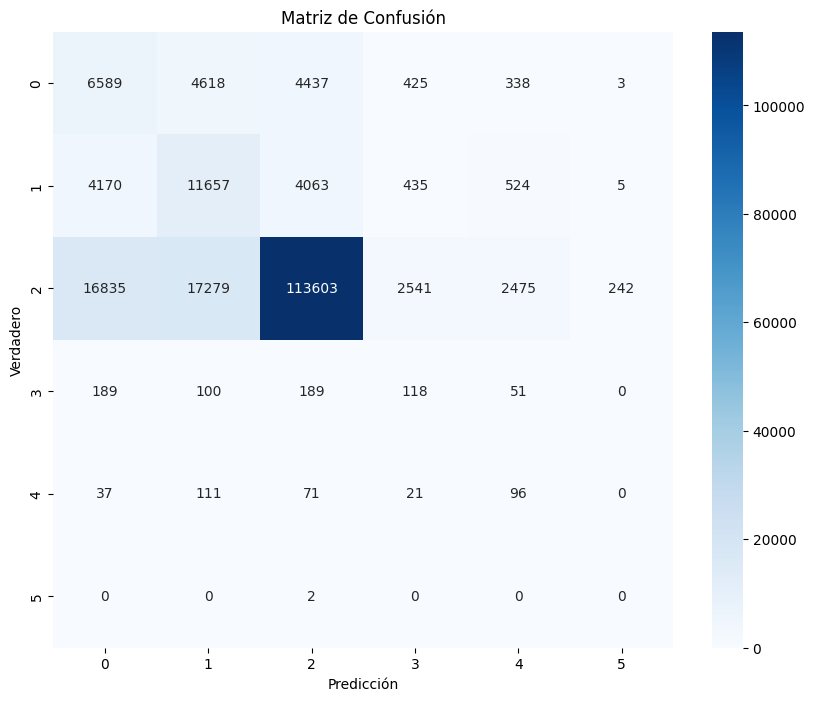


Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.2368    0.4015    0.2979     16410
           1     0.3452    0.5590    0.4268     20854
           2     0.9284    0.7426    0.8252    152975
           3     0.0333    0.1824    0.0564       647
           4     0.0276    0.2857    0.0503       336
           5     0.0000    0.0000    0.0000         2

    accuracy                         0.6906    191224
   macro avg     0.2619    0.3619    0.2761    191224
weighted avg     0.8008    0.6906    0.7325    191224


ROC-AUC global (One-vs-Rest): 0.7134


In [ ]:
# 1. Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy global: {accuracy:.4f}")

# 2. Precision
precision = precision_score(y_true, y_pred, average=None)
print("\nPrecisión por clase:")
for cls, pr in enumerate(precision):
    print(f"Clase {cls}: {pr:.4f}")

# 3. Recall
recall = recall_score(y_true, y_pred, average=None)
print("\nRecall por clase:")
for cls, rc in enumerate(recall):
    print(f"Clase {cls}: {rc:.4f}")

# 4. F1-Score
f1 = f1_score(y_true, y_pred, average=None)
print("\nF1-Score por clase:")
for cls, f in enumerate(f1):
    print(f"Clase {cls}: {f:.4f}")

# 5. Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(y_test_one_hot.shape[1]), yticklabels=range(y_test_one_hot.shape[1]))
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión')
plt.show()

# 6. Classification Report
print("\nReporte de clasificación:")
print(classification_report(y_true, y_pred, digits=4))

# 7. ROC-AUC (solo si hay probabilidades predichas)
if y_test_one_hot.shape[1] > 2:  # Multiclase
    roc_auc = roc_auc_score(y_test_one_hot, y_pred_prob, multi_class="ovr")
    print(f"\nROC-AUC global (One-vs-Rest): {roc_auc:.4f}")
else:  # Binaria
    roc_auc = roc_auc_score(y_true, y_pred_prob[:, 1])
    print(f"\nROC-AUC global: {roc_auc:.4f}")

    RocCurveDisplay.from_predictions(y_true, y_pred_prob[:, 1])
    plt.title('Curva ROC')
    plt.show()

    PrecisionRecallDisplay.from_predictions(y_true, y_pred_prob[:, 1])
    plt.title('Curva de Precisión-Recall')
    plt.show()

### Analisis de los resultados del modelo:

El modelo utilizó SMOTE para intentar solucionar el problema de desbalance de clases y Keras Tuner para ajustar su arquitectura y la tasa de aprendizaje. Esto ayudó a equilibrar los datos y a configurar el modelo para un mejor rendimiento en los datos de validación.

Gracias a SMOTE, se logró igualar la cantidad de ejemplos entre clases, reduciendo el sesgo hacia la clase mayoritaria. Sin embargo, esta técnica también tiene sus contras, ya que al crear datos sintéticos, puede introducir ruido que dificulte el aprendizaje, especialmente en las clases minoritarias.

Con Keras Tuner se pudieron probar distintas configuraciones de capas, unidades y tasas de aprendizaje, logrando un modelo con precisión global del 67.63%. Aunque esto es un avance, el rendimiento sigue siendo desigual entre las clases. La clase 2, por tener más datos representativos, se clasificó muy bien, con una precisión del 93.31% y un recall del 72.27%. En cambio, las clases más pequeñas (3, 4 y 5) quedaron rezagadas, con métricas de precisión y recall muy bajas, y la clase 5 ni siquiera se predijo correctamente.

El modelo aún está claramente sesgado hacia la clase mayoritaria, lo que complica generalizarlo a las clases menos representadas. Esto demuestra que, aunque se avanzó, las técnicas usadas no son suficientes para resolver del todo el problema.

Para mejorar, se podrían probar otras soluciones como ADASYN, que crea ejemplos sintéticos más representativos, o aplicar pesos a las clases minoritarias para que el modelo las tome más en cuenta. También sería interesante probar arquitecturas más avanzadas, como redes convolucionales o LSTMs, si los datos lo permiten. Además, sumar ejemplos reales de las clases más pequeñas podría ser más efectivo que seguir creando datos sintéticos.

En resumen, aunque el modelo mejoró en general, sigue costando mucho clasificar bien las clases minoritarias, y sería bueno explorar nuevas ideas para cerrar esa brecha.

Nuevo modelo en base al anterior utilizando nuevo metodo ADASYN (Adaptive Synthetic Sampling) para generar datos sintéticos más representativos

Pesos por clase ajustados: {0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0), 3: np.float64(1.0), 4: np.float64(1.0), 5: np.float64(1.0)}
Epoch 1/50
45945/45945 ━━━━━━━━━━━━━━━━━━━━ 100s 2ms/step - accuracy: 0.6855 - loss: 0.7974 - val_accuracy: 0.6384 - val_loss: 0.8634 - learning_rate: 1.0000e-04
Epoch 2/50
45945/45945 ━━━━━━━━━━━━━━━━━━━━ 100s 2ms/step - accuracy: 0.7739 - loss: 0.5483 - val_accuracy: 0.6643 - val_loss: 0.8247 - learning_rate: 1.0000e-04
Epoch 3/50
45945/45945 ━━━━━━━━━━━━━━━━━━━━ 98s 2ms/step - accuracy: 0.7862 - loss: 0.5127 - val_accuracy: 0.6622 - val_loss: 0.8338 - learning_rate: 1.0000e-04
Epoch 4/50
45945/45945 ━━━━━━━━━━━━━━━━━━━━ 97s 2ms/step - accuracy: 0.7930 - loss: 0.4948 - val_accuracy: 0.6848 - val_loss: 0.7972 - learning_rate: 1.0000e-04
Epoch 5/50
45945/45945 ━━━━━━━━━━━━━━━━━━━━ 96s 2ms/step - accuracy: 0.7968 - loss: 0.4845 - val_accuracy: 0.7069 - val_loss: 0.7691 - learning_rate: 1.0000e-04
Epoch 6/50
45945/45945 ━━━━━━━━━━━━━━━━━━━━ 9

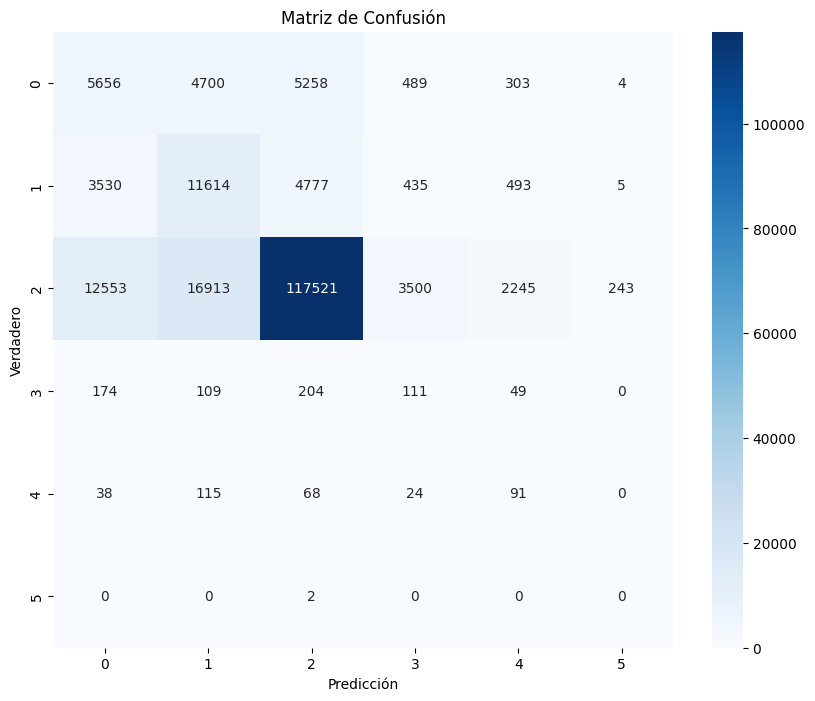

In [ ]:
# Calcular los pesos por clase
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_resampled),
    y=y_train_resampled
)

# Convertir los pesos a un diccionario
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Pesos por clase ajustados:", class_weights_dict)

# Obtener los mejores hiperparámetros encontrados por Keras Tuner
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Configuración del modelo con los mejores parámetros de Keras Tuner
model = models.Sequential()

# Construir las capas ocultas según los hiperparámetros encontrados
for i in range(best_hps.get('num_layers')):  # Número de capas ocultas
    model.add(layers.Dense(
        units=best_hps.get(f'units_{i}'),  # Número de unidades por capa
        activation='relu'))
    model.add(layers.BatchNormalization())  # Regularización

# Capa de salida
model.add(layers.Dense(y_train_final.shape[1], activation='softmax'))

# Compilar el modelo con la mejor tasa de aprendizaje
opt = Adam(learning_rate=best_hps.get('learning_rate'))  # Tasa de aprendizaje óptima
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Entrenar el modelo con ADASYN y pesos por clase
history = model.fit(
    x_train_resampled, y_train_resampled_one_hot,
    validation_data=(x_val, y_val),
    batch_size=64,  # Mantener un tamaño de batch razonable
    epochs=50,  # Limitar a 50 épocas para evitar sobreentrenamiento
    class_weight=class_weights_dict,  # Usar pesos por clase ajustados
    callbacks=[early_stopping, reduce_lr],  # Callbacks para regularización dinámica
    verbose=1
)

# Evaluación del modelo
y_pred_prob = model.predict(x_test_encoded)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_one_hot, axis=1)

# Métricas de rendimiento
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("\nReporte de clasificación:")
print(classification_report(y_true, y_pred))

# Matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión')
plt.show()



### Modelo

Accuracy global: 0.7059

Precisión por clase:
Clase 0: 0.2577
Clase 1: 0.3472
Clase 2: 0.9194
Clase 3: 0.0243
Clase 4: 0.0286
Clase 5: 0.0000

Recall por clase:
Clase 0: 0.3447
Clase 1: 0.5569
Clase 2: 0.7682
Clase 3: 0.1716
Clase 4: 0.2708
Clase 5: 0.0000

F1-Score por clase:
Clase 0: 0.2949
Clase 1: 0.4277
Clase 2: 0.8370
Clase 3: 0.0426
Clase 4: 0.0517
Clase 5: 0.0000


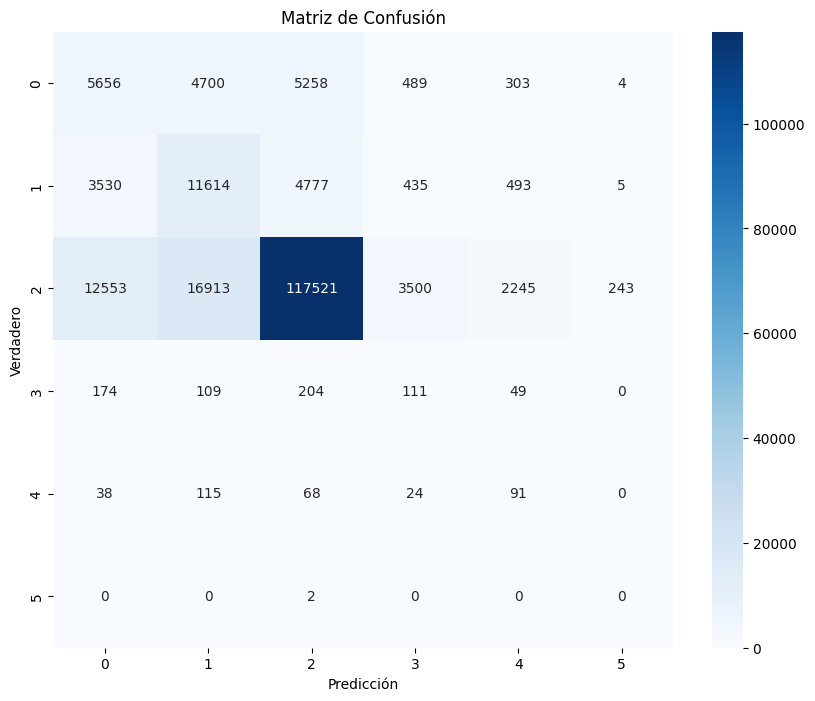


Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.2577    0.3447    0.2949     16410
           1     0.3472    0.5569    0.4277     20854
           2     0.9194    0.7682    0.8370    152975
           3     0.0243    0.1716    0.0426       647
           4     0.0286    0.2708    0.0517       336
           5     0.0000    0.0000    0.0000         2

    accuracy                         0.7059    191224
   macro avg     0.2629    0.3520    0.2757    191224
weighted avg     0.7956    0.7059    0.7418    191224


ROC-AUC global (One-vs-Rest): 0.6745


In [ ]:
# 1. Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy global: {accuracy:.4f}")

# 2. Precision
precision = precision_score(y_true, y_pred, average=None)
print("\nPrecisión por clase:")
for cls, pr in enumerate(precision):
    print(f"Clase {cls}: {pr:.4f}")

# 3. Recall
recall = recall_score(y_true, y_pred, average=None)
print("\nRecall por clase:")
for cls, rc in enumerate(recall):
    print(f"Clase {cls}: {rc:.4f}")

# 4. F1-Score
f1 = f1_score(y_true, y_pred, average=None)
print("\nF1-Score por clase:")
for cls, f in enumerate(f1):
    print(f"Clase {cls}: {f:.4f}")

# 5. Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(y_test_one_hot.shape[1]),
            yticklabels=range(y_test_one_hot.shape[1]))
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión')
plt.show()

# 6. Classification Report
print("\nReporte de clasificación:")
print(classification_report(y_true, y_pred, digits=4))

# 7. ROC-AUC (solo si hay probabilidades predichas)
if y_test_one_hot.shape[1] > 2:  # Multiclase
    roc_auc = roc_auc_score(y_test_one_hot, y_pred_prob, multi_class="ovr")
    print(f"\nROC-AUC global (One-vs-Rest): {roc_auc:.4f}")
else:  # Binaria
    roc_auc = roc_auc_score(y_true, y_pred_prob[:, 1])
    print(f"\nROC-AUC global: {roc_auc:.4f}")

    # Curva ROC
    RocCurveDisplay.from_predictions(y_true, y_pred_prob[:, 1])
    plt.title('Curva ROC')
    plt.show()

    # Curva de Precisión-Recall
    PrecisionRecallDisplay.from_predictions(y_true, y_pred_prob[:, 1])
    plt.title('Curva de Precisión-Recall')
    plt.show()


## Resultados en las métricas de rendimiento
Se observa una leve mejoria en cuanto a las metricas manteniendo la misma estructura al utilizar el metodo ADASYN.

Accuracy Global (69.99%): El modelo sigue tiniendo un desempeño general moderado. Esto refleja que el modelo es capaz de clasificar correctamente una buena parte de las muestras, pero no todas.

Precisión y Recall por Clase:La clase 2 sigue dominando el desempeño del modelo con una precisión (92.18%) y un recall (75.89%) elevados. Esto indica que el modelo maneja bien las clases mayoritarias o aquellas con más ejemplos representativos.Las clases minoritarias como la clase 3 y la clase 4 tienen métricas muy bajas (precisión < 5% y recall < 40%), lo que sugiere que el modelo tiene dificultades para generalizar sobre estas categorías, incluso después de aplicar SMOTE.La clase 5 no fue predicha correctamente, reflejando problemas en el aprendizaje de esta clase extremadamente minoritaria.
F1-Score: La métrica F1 (combinación de precisión y recall) muestra que el modelo tiene un buen desempeño en la clase 2 (83.25%),levemente superior mientras que las demás clases tienen valores extremadamente bajos (< 30%), indicando un desequilibrio en el rendimiento entre clases.

Se observan algunas limitaciones como:

Problemas con clases minoritarias: A pesar de SMOTE y los ajustes de arquitectura, el modelo aún tiene problemas para clasificar correctamente clases con muy pocos ejemplos (clases 3, 4, y 5). Esto puede deberse a:
Datos insuficientes o no representativos para estas clases.

Ruido introducido por SMOTE en las clases minoritarias.

Sesgo hacia clases mayoritarias: La alta precisión en la clase 2 sugiere que el modelo sigue sesgado hacia las clases dominantes, lo que afecta su capacidad para generalizar a todas las categorías.


##### Conclusión parcial

El modelo planteado muestra un desempeño un poco mejor en clases dominantes pero sigue presentando dificultades con las clases minoritarias, incluso después de aplicar SMOTE,usando un nuevo metodo . Esto resalta la importancia de complementar técnicas de balanceo de datos con ajustes arquitectónicos y exploración de datos adicionales para mejorar el rendimiento global.

La nueva metrica (ROC-AUC) a analizar de 0.7260 refleja desempeño general moderado,pero al estar influenciado por el buen desempeño en la clase mayoritaria (clase 2) puede enmascarar limitaciones en la generalización para clases minoritarias.Esto implica que el modelo sigue sesgado hacia las clases mayoritarias y no aprovecha plenamente las técnicas de balanceo aplicadas.

## Conclusiones finales

Se evaluaron diversas variantes de modelos, incluyendo ajustes en arquitecturas y optimización de hiperparámetros, logrando mejorar las métricas de desempeño y obteniendo resultados aceptables. A pesar de ello, persiste un marcado desbalanceo en la distribución de las clases, donde la clase 2 destaca como dominante. Este desbalanceo limita la capacidad del modelo para mejorar aún más la precisión, especialmente en las clases minoritarias.

En términos generales, el modelo cumplió con las expectativas, alcanzando una precisión global superior al 65%. Sin embargo, predecir el estatus de cada crimen con mayor exactitud sigue siendo un desafío, dadas las limitaciones inherentes a las herramientas y técnicas empleadas hasta ahora.

Recomendación:

Para mejorar la capacidad predictiva del modelo, se sugiere implementar técnicas de Transfer Learning, utilizando un modelo preentrenado en problemas de clasificación multiclase que presenten escenarios similares, es decir, con clases desbalanceadas y una categoría dominante. Esto permitiría al modelo aprovechar características aprendidas previamente y mejorar su desempeño en la clasificación de las clases minoritarias.